# Отчет по прогнозированию временных рядов с использованием CatBoostForecaster

## 1. Описание реализованного класса `CatBoostForecaster`

Класс `CatBoostForecaster` представляет собой программный модуль для прогнозирования временных рядов на основе алгоритма градиентного бустинга **CatBoost**. Данный класс реализует подход машинного обучения, преобразуя задачу прогнозирования в задачу регрессии путем генерации признаков из исторических данных. Класс предназначен для построения индивидуальных моделей прогнозирования для каждой товарной позиции (`item_id`) в рамках указанного магазина (`store_id`).

### 1.1. Основные атрибуты класса:

*   `items_data`: Словарь (`dict`), хранящий `pd.DataFrame` с предобработанными данными и сгенерированными признаками для каждого `item_id`.
*   `items`: Список (`list`) уникальных `item_id`, для которых были успешно подготовлены данные.
*   `models`: Словарь (`dict`) для хранения обученных экземпляров `CatBoostRegressor`.
*   `forecasts`: Словарь (`dict`) для хранения `pd.DataFrame` с результатами прогнозов.
*   `metrics`: Словарь (`dict`) для хранения рассчитанных метрик качества прогнозов.
*   `store_id`: Идентификатор (`str`) анализируемого магазина.
*   `features`, `target`, `cat_features`: Списки (`list`) имен признаков, целевой переменной и категориальных признаков соответственно.
*   `_full_dates_data`: Приватный атрибут для хранения исходных календарных данных.

### 1.2. Основные методы класса и результаты их работы (на примере `STORE_1`):

1.  **`load_and_preprocess_data`**:
    *   *Функционал:* Загрузка исходных данных (продажи, цены, календарь), фильтрация по `store_id`, интеграция данных, базовая агрегация по дням для каждого `item_id`, обработка пропусков цен (**методами `ffill` и `bfill`** внутри группы товаров), линейная интерполяция для `cnt`, обеспечение непрерывности временного ряда.
    *   *Результат (из логов):* Данные отфильтрованы по `STORE_1`, идентифицировано 15 уникальных товаров. Базовая предобработка выполнена для периода с 2011-01-29 по 2016-01-21.

2.  **`add_time_features`**:
    *   *Функционал:* Генерация признаков для модели CatBoost: лаги `cnt` (до 35 дней), скользящие статистики `cnt` (среднее, std для окон 7-28 дней), разница скользящих средних, признаки цены (лаги, разница), расширенные календарные признаки (включая циклические и взаимодействия), **типы событий (`event_type_1`, `event_type_2`) как категориальные признаки**, кэшбэк. Удаление строк с `NaN`, возникших при генерации признаков.
    *   *Результат:* Создание расширенного набора признаков для каждого `item_id`.

3.  **`train_test_split`**:
    *   *Функционал:* Применение `add_time_features` и разделение данных с признаками на обучающую и тестовую выборки (80%/20%).
    *   *Результат (из логов):* Данные разделены для 15 товаров `STORE_1`. Обучающий период (после `dropna`): 2011-03-05 - 2015-01-29. Тестовый период: 2015-01-30 - 2016-01-21.

4.  **`prepare_features_targets`**:
    *   *Функционал:* Формирование матрицы признаков (X) и вектора целевой переменной (y) для передачи в модель CatBoost. **Идентификация категориальных признаков**, включая типы событий и `item_id`.

5.  **`train_catboost_model`**:
    *   *Функционал:* Обучение модели `CatBoostRegressor` для заданного `item_id` с фиксированными гиперпараметрами (`loss_function='MAE'`, `iterations=700`, `learning_rate=0.03`, `verbose=False`), **с передачей списка категориальных признаков** для внутренней обработки моделью.
    *   *Результат (из логов):* Для каждой модели выводится топ-10 признаков по важности. Например, для `STORE_1_064` наиболее важны `cnt_lag_1`, `cnt_rolling_std_7`, `cnt_lag_2`; для `STORE_1_065` важны также `event_type_2`; для `STORE_1_325` - `CASHBACK_STORE_1`.

6.  **`forecast`**:
    *   *Функционал:* Генерация **итеративного** прогноза на заданный горизонт (`week`, `month`, `quarter`). На каждом шаге прогнозирования признаки пересчитываются с использованием ранее сгенерированных прогнозов.

7.  **`evaluate`**:
    *   *Функционал:* Расчет метрик MAE, RMSE, MAPE, R2 путем сравнения итеративного прогноза с фактическими данными тестовой выборки на соответствующем горизонте.
    *   *Результат (из логов):* Выводятся рассчитанные метрики для каждого товара и горизонта (см. раздел 4.2).

8.  **`visualize_forecast`**:
    *   *Функционал:* Построение графика для визуального сравнения прогноза и фактических данных.

9.  **`run_all`**:
    *   *Функционал:* Оркестрация полного цикла (обучение, прогноз на все горизонты, оценка, визуализация) для одного `item_id`.
    *   *Результат (из логов):* Вывод итоговой таблицы с метриками для всех горизонтов по конкретному товару.

10. **`run_all_items`**:
    *   *Функционал:* Применение `run_all` ко всем `item_id` магазина, агрегация результатов. (Использовался в скрипте запуска для получения итоговых метрик).

---

## 2. Ответы на вопросы

### 2.1 Какие методы предобработки данных вы использовали? Почему пробовали именно их?

Использовался двухэтапный подход к предобработке данных, адаптированный для последующего применения модели машинного обучения CatBoost.

**Этап 1: Базовая подготовка временного ряда:**

1.  **Фильтрация по `store_id` (`STORE_1`):** Обеспечение гомогенности данных и специфичности модели для конкретной торговой точки.
2.  **Интеграция данных:** Объединение данных о продажах, ценах, календарных событиях и акциях (кэшбэк) для формирования полного контекста наблюдений.
3.  **Временная агрегация:** Приведение данных к дневной гранулярности путем агрегации (суммирование `cnt`, усреднение `sell_price`, сохранение категориальных признаков). Стандартный шаг для работы с моделями временных рядов.
4.  **Обработка пропусков цен:** Заполнение пропусков с использованием **`ffill()` и `bfill()`** внутри группы каждого товара. *Обоснование:* Этот метод лучше сохраняет последнюю известную цену, что часто является более реалистичным предположением, чем заполнение средним значением по всему периоду.
5.  **Обработка нулевых продаж (`cnt`):** Замена нулей на `NaN` с последующей **линейной интерполяцией**. *Обоснование:* Нулевые значения могут искажать статистические свойства ряда. Линейная интерполяция выбрана как метод, сохраняющий локальные тенденции.
6.  **Обеспечение непрерывности дат (`reindex`):** Гарантия отсутствия пропусков во временной оси.

**Этап 2: Генерация признаков (Feature Engineering) (`add_time_features`):**

1.  **Лаги целевой переменной (`cnt_lag_*`):** Включение прошлых значений `cnt` (до 35 дней). *Обоснование:* Явное кодирование авторегрессионной зависимости.
2.  **Скользящие статистики (`cnt_rolling_*`):** Расчет среднего и стандартного отклонения `cnt` за различные временные окна (7-28 дней). *Обоснование:* Количественная характеристика недавнего уровня, тренда и волатильности ряда.
3.  **Разница скользящих средних:** Признак, отражающий изменение в динамике локального тренда.
4.  **Признаки цены (`sell_price_diff_1`, `sell_price_lag_*`):** Включение информации о недавнем изменении цены и прошлых значениях. *Обоснование:* Учет ценовой эластичности спроса.
5.  **Календарные признаки (расширенные):** Генерация признаков на основе даты (день недели, месяц, год, день года, квартал, неделя года), включая циклические представления (sin/cos) и флаги (выходной). *Обоснование:* Явное моделирование сезонности и календарных эффектов.
6.  **Признаки событий (типы):** Использование столбцов `event_type_1` и `event_type_2` **напрямую как категориальные признаки**. *Обоснование:* CatBoost эффективно обрабатывает категориальные признаки внутренними методами, что избавляет от необходимости ручного One-Hot Encoding и может повысить качество модели.
7.  **Другие признаки:** Включение данных о кэшбэке и идентификатора товара (`item_id`) как категориального признака. *Обоснование:* Учет специфических промо-акций и возможности построения единой модели (хотя в данном классе модели индивидуальны).
8.  **Удаление NaN (`dropna`):** Исключение начальных периодов, для которых невозможно рассчитать лаги и скользящие статистики. *Обоснование:* Обеспечение полноты данных для входа в модель.

**Общее обоснование:** Выбранные методы направлены на преобразование временного ряда в формат "объект-признак" для CatBoost. Признаки кодируют авторегрессию, тренд, сезонность, волатильность и влияние внешних факторов (цена, события, акции). Использование `ffill`/`bfill` для цен и прямой обработки категорий событий являются улучшениями по сравнению с предыдущими подходами.

### 2.2 Какие модели пробовали? Почему пробовали именно их?

В рамках класса `CatBoostForecaster` был использован и протестирован **только один тип модели**:

1.  **`CatBoostRegressor`**: Модель, основанная на алгоритме градиентного бустинга над деревьями решений.

**Обоснование выбора `CatBoostRegressor`:**

*   **Современный ML-подход:** Выбор обусловлен стремлением применить современный метод машинного обучения, часто показывающий высокую точность на табличных данных и в задачах прогнозирования временных рядов (при соответствующей подготовке признаков).
*   **Эффективность градиентного бустинга:** Алгоритмы градиентного бустинга способны строить мощные модели, выявляя сложные нелинейные зависимости и взаимодействия признаков.
*   **Работа с категориальными признаками:** **Ключевое преимущество CatBoost** – встроенная и эффективная обработка категориальных признаков (включая типы событий и `item_id`), что упрощает предобработку и потенциально повышает качество модели.


### 2.3 Как вы проверяете качество модели? На каких данных? Какие метрики используете? Чем обусловлен выбор именно этих метрик?

**Процедура проверки качества:**

*   **Метод валидации:** Оценка на отложенной (hold-out) тестовой выборке. Прогнозирование выполняется **итеративно**: модель генерирует прогноз на один шаг вперед, этот прогноз используется для расчета признаков для следующего шага, и так далее на весь горизонт. Это имитирует реальное применение модели.
*   **Данные для проверки:** Используется **тестовая выборка**, сформированная после генерации признаков и удаления строк с NaN. Для магазина `STORE_1` тестовый период охватывает даты с **2015-01-30 по 2016-01-21**. Оценка качества производится отдельно для трех горизонтов прогнозирования: **неделя** (первые 7 дней тестового периода), **месяц** (первые 30 дней) и **квартал** (первые 90 дней).
*   **Метрики качества:** Используется стандартный набор метрик:
    1.  **MAE (Mean Absolute Error):** Средняя абсолютная ошибка (в единицах `cnt`).
    2.  **RMSE (Root Mean Squared Error):** Корень из среднеквадратичной ошибки (в единицах `cnt`, штрафует за большие ошибки).
    3.  **MAPE (Mean Absolute Percentage Error):** Средняя абсолютная процентная ошибка (относительная ошибка).
    4.  **R² (Coefficient of Determination):** Коэффициент детерминации (доля объясненной дисперсии).

**Обоснование выбора метрик:**
*   **Комплексная оценка:** Набор метрик позволяет оценить качество с разных сторон: абсолютную (MAE, RMSE), относительную (MAPE) и общую адекватность (R²).
*   **Интерпретируемость:** MAE и MAPE легко интерпретируются.
*   **Чувствительность к ошибкам:** Сравнение MAE и RMSE помогает судить о наличии выбросов.
*   **Сравнимость:** Стандартные метрики позволяют сравнивать результаты с другими моделями.


# 3. Предсказания реализованного класса CatBoostForecaster для разных горизонтов

D:\setup\anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Загрузка и предобработка данных для магазина: STORE_1...
Данные отфильтрованы по магазину: STORE_1
Найдено 15 уникальных товаров в магазине STORE_1
Данные загружены и предобработаны для 15 товаров.
Период данных: 2011-01-29 по 2016-01-21
Разделение данных на обучающую/тестовую выборки (test_size=0.2)...
Разделение данных завершено для 15 товаров.
Агрегированный период обучения: 2011-03-05 по 2015-01-29
Агрегированный период теста:  2015-01-30 по 2016-01-21

Начинаем прогнозирование для 15 товаров...

=== Прогнозирование по товару STORE_1_064 ===
Обучение модели CatBoost для cnt для товара STORE_1_064...

Топ-10 важных признаков для товара STORE_1_064:
                   Feature  Importance
                 cnt_lag_1   48.267437
         cnt_rolling_std_7    6.990367
                 cnt_lag_2    6.241288
cnt_rolling_mean_7_28_diff    4.241107
                 cnt_lag_3    3.848562
        cnt_rolling_mean_7    3.233332
                 cnt_lag_7    2.234247
        cnt_rolling_std_14  

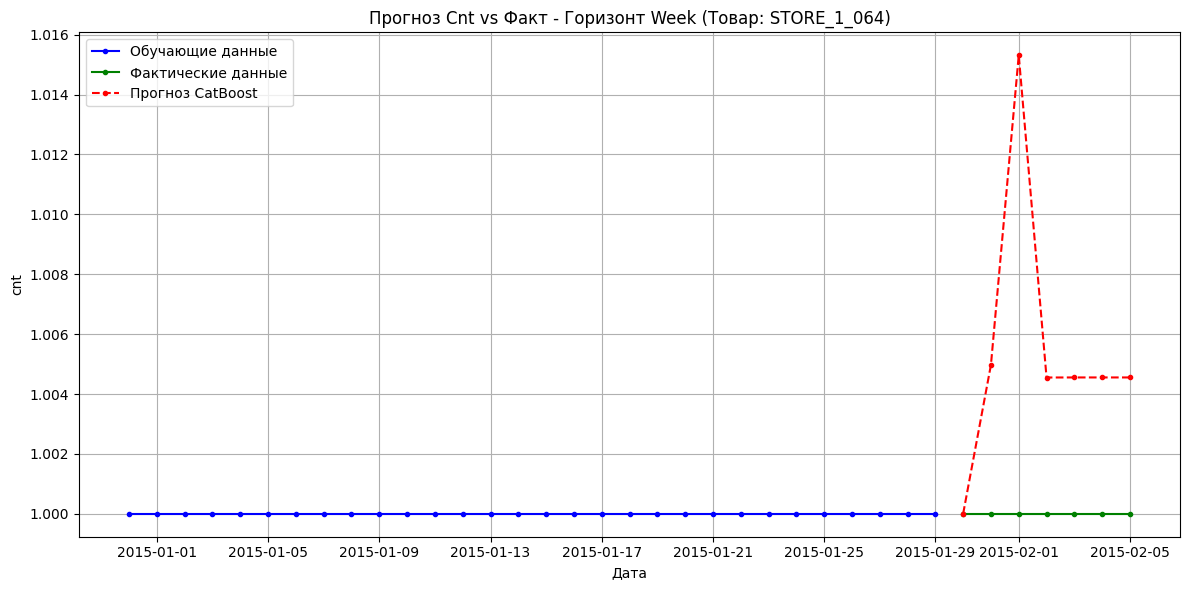

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_064...
Метрики оценки (горизонт month) для товара STORE_1_064:
  MAE:  0.29
  RMSE: 0.42
  MAPE: 26.07%
  R2:   -2.81


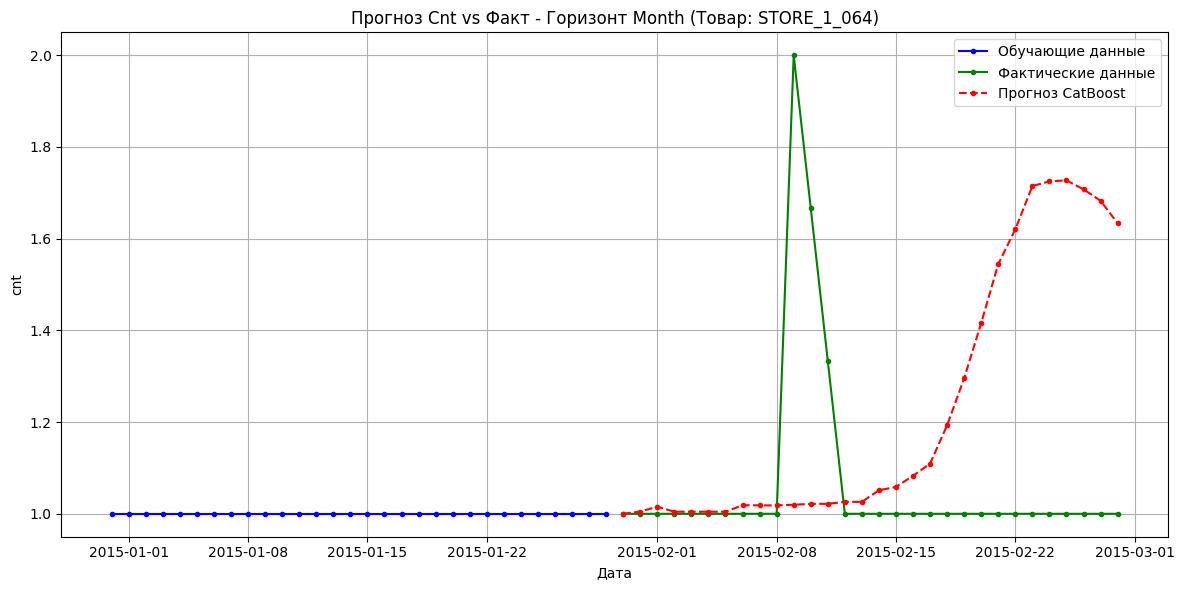

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_064...
Метрики оценки (горизонт quarter) для товара STORE_1_064:
  MAE:  0.36
  RMSE: 0.45
  MAPE: 28.11%
  R2:   -0.40


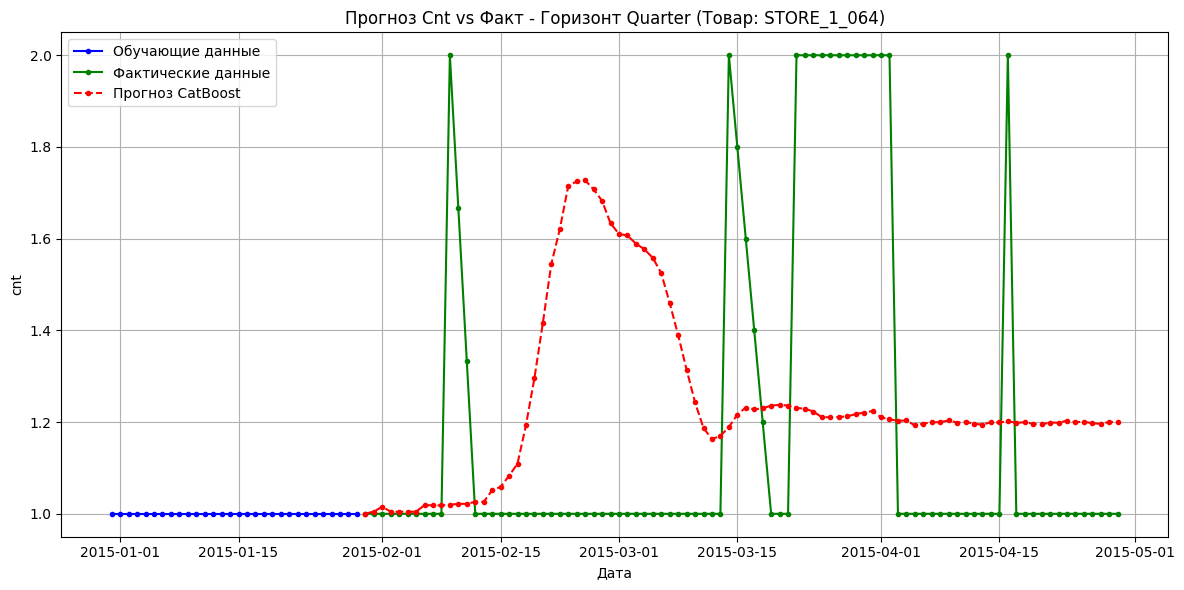


--- Итоговые результаты для товара STORE_1_064 ---
Horizon  MAE  RMSE  MAPE    R2
   week 0.01  0.01  0.55  0.00
  month 0.29  0.42 26.07 -2.81
quarter 0.36  0.45 28.11 -0.40
Модель сохранена: models\catboost_STORE_1_064_cnt_model.cbm

=== Прогнозирование по товару STORE_1_065 ===
Обучение модели CatBoost для cnt для товара STORE_1_065...

Топ-10 важных признаков для товара STORE_1_065:
                   Feature  Importance
                 cnt_lag_1   44.789884
         cnt_rolling_std_7    5.262643
                 cnt_lag_2    4.509860
                 cnt_lag_3    3.757130
        cnt_rolling_mean_7    3.446338
              event_type_2    3.098632
       cnt_rolling_mean_14    2.387347
        cnt_rolling_std_21    2.297359
cnt_rolling_mean_7_28_diff    2.165377
       cnt_rolling_mean_21    1.968643
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_065...
Метрики оценки (горизонт week) для товара STORE_1_065:
  MAE:  0.07
  RMSE: 0.12
  MAPE: 7.24%
  R2:   0.00


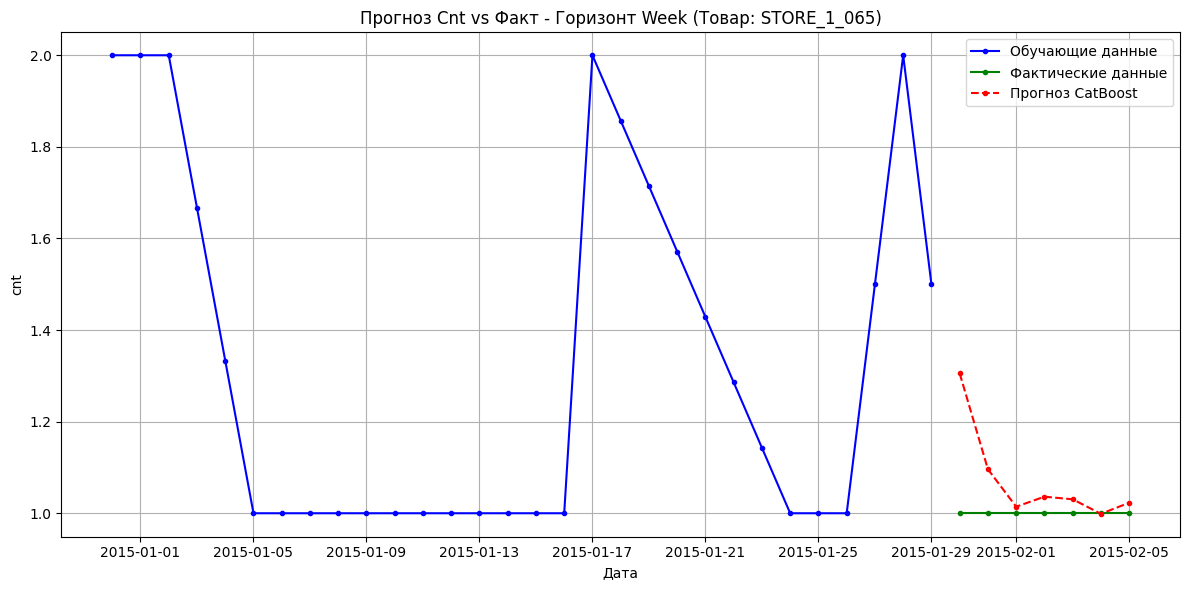

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_065...
Метрики оценки (горизонт month) для товара STORE_1_065:
  MAE:  0.31
  RMSE: 0.54
  MAPE: 17.13%
  R2:   -0.37


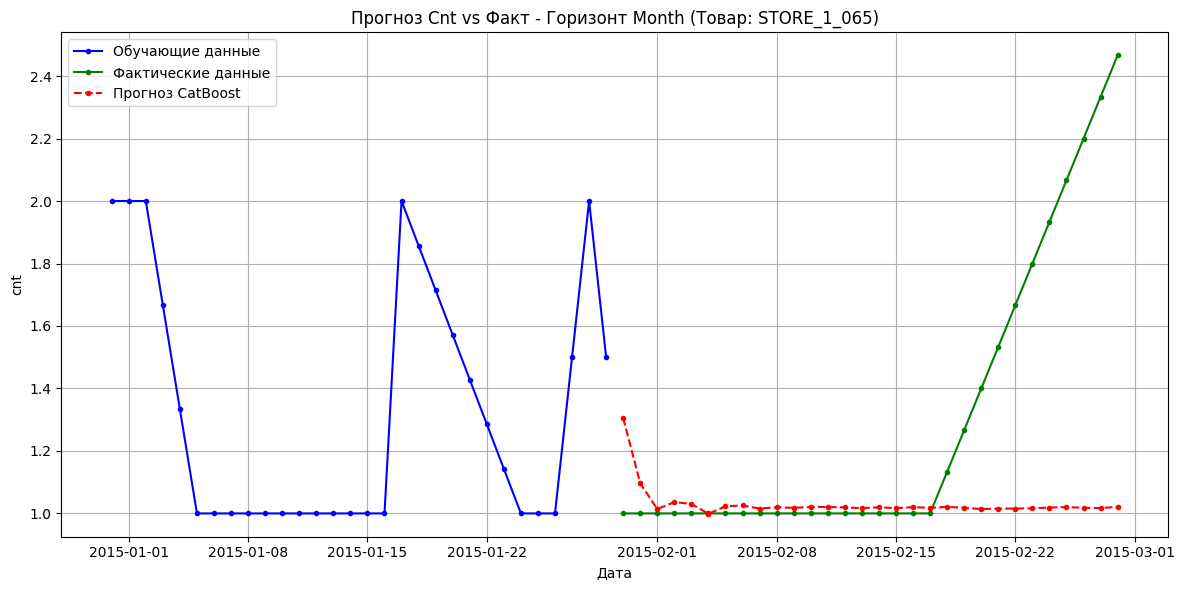

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_065...
Метрики оценки (горизонт quarter) для товара STORE_1_065:
  MAE:  0.44
  RMSE: 0.69
  MAPE: 22.60%
  R2:   -0.59


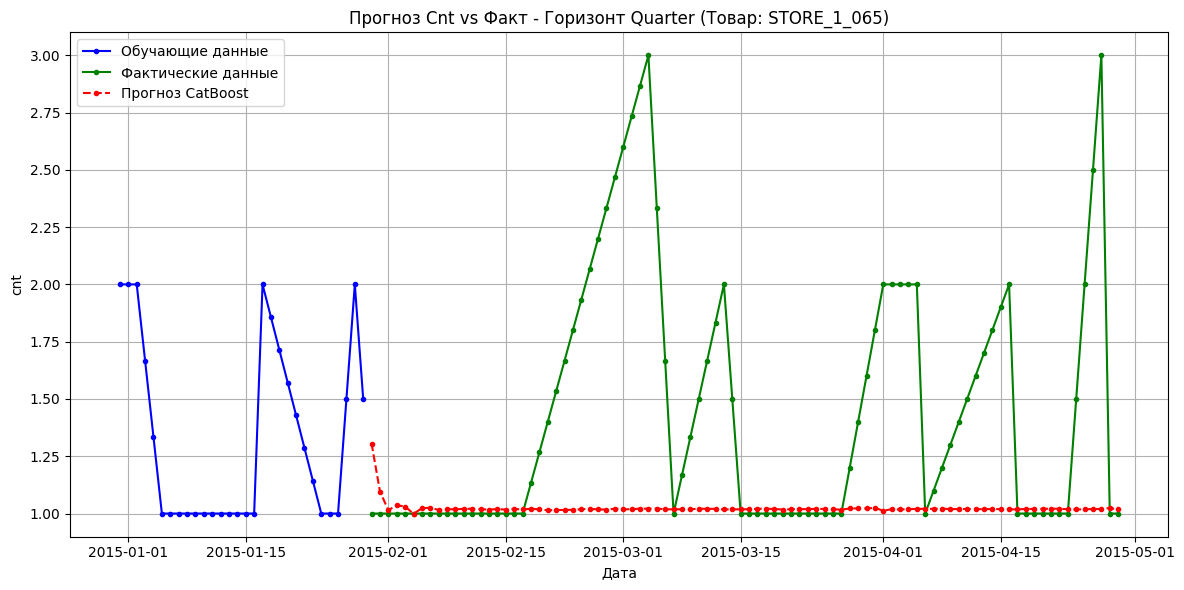


--- Итоговые результаты для товара STORE_1_065 ---
Horizon  MAE  RMSE  MAPE    R2
   week 0.07  0.12  7.24  0.00
  month 0.31  0.54 17.13 -0.37
quarter 0.44  0.69 22.60 -0.59
Модель сохранена: models\catboost_STORE_1_065_cnt_model.cbm

=== Прогнозирование по товару STORE_1_325 ===
Обучение модели CatBoost для cnt для товара STORE_1_325...

Топ-10 важных признаков для товара STORE_1_325:
                   Feature  Importance
        cnt_rolling_mean_7   12.320486
          CASHBACK_STORE_1    6.269294
cnt_rolling_mean_7_28_diff    5.605052
                cnt_lag_28    5.163530
                 cnt_lag_2    4.636160
         cnt_rolling_std_7    4.565510
                 cnt_lag_1    4.486302
                       day    4.134424
       cnt_rolling_mean_14    3.949764
                      year    3.201864
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_325...
Метрики оценки (горизонт week) для товара STORE_1_325:
  MAE:  1.85
  RMSE: 2.10
  MAPE: 79.99%
  R2:   -0.13


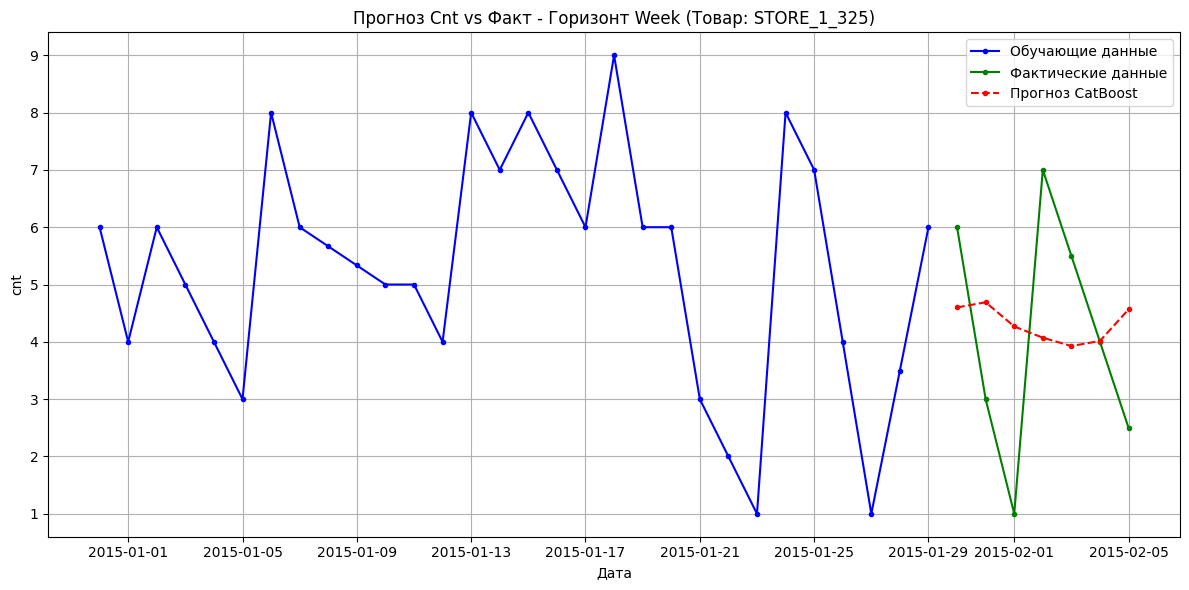

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_325...
Метрики оценки (горизонт month) для товара STORE_1_325:
  MAE:  3.80
  RMSE: 5.20
  MAPE: 73.43%
  R2:   -0.41


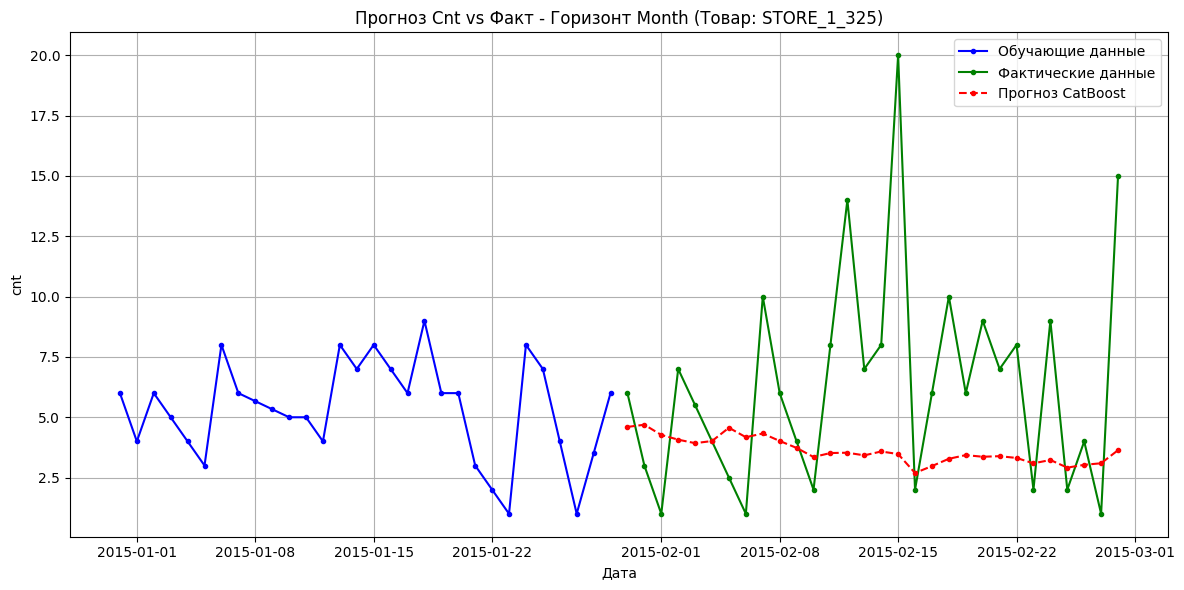

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_325...
Метрики оценки (горизонт quarter) для товара STORE_1_325:
  MAE:  4.19
  RMSE: 5.40
  MAPE: 66.11%
  R2:   -0.67


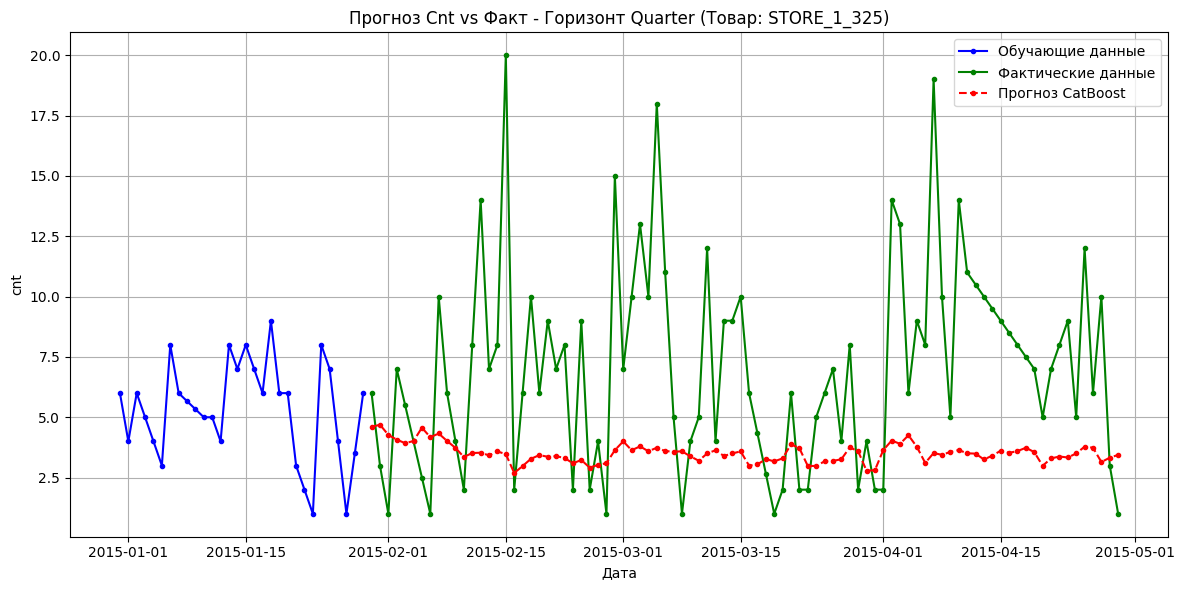


--- Итоговые результаты для товара STORE_1_325 ---
Horizon  MAE  RMSE  MAPE    R2
   week 1.85   2.1 79.99 -0.13
  month 3.80   5.2 73.43 -0.41
quarter 4.19   5.4 66.11 -0.67
Модель сохранена: models\catboost_STORE_1_325_cnt_model.cbm

=== Прогнозирование по товару STORE_1_376 ===
Обучение модели CatBoost для cnt для товара STORE_1_376...

Топ-10 важных признаков для товара STORE_1_376:
                   Feature  Importance
                 cnt_lag_1   26.698962
        cnt_rolling_mean_7    6.907650
         cnt_rolling_std_7    6.581416
                 cnt_lag_2    5.121930
cnt_rolling_mean_7_28_diff    4.229579
                 cnt_lag_3    3.573005
                 cnt_lag_7    3.570018
                 dayofyear    3.294108
              event_type_1    2.869962
       cnt_rolling_mean_21    2.595790
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_376...
Метрики оценки (горизонт week) для товара STORE_1_376:
  MAE:  0.14
  RMSE: 0.18
  MAPE: 9.54%
  R2:   0.73


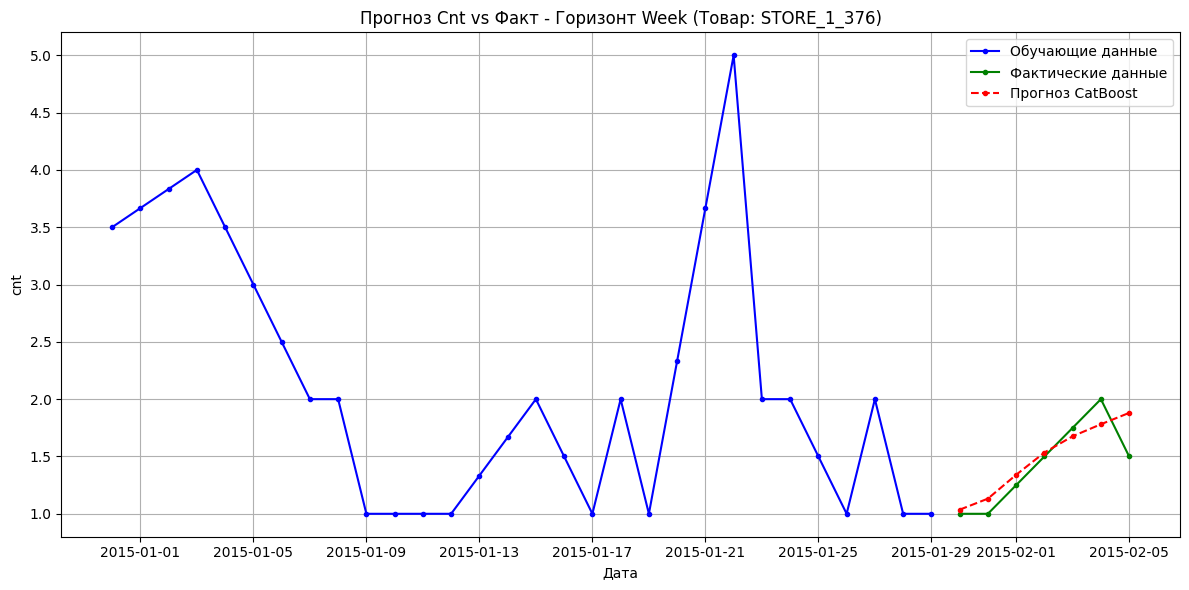

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_376...
Метрики оценки (горизонт month) для товара STORE_1_376:
  MAE:  0.79
  RMSE: 1.19
  MAPE: 34.38%
  R2:   -0.17


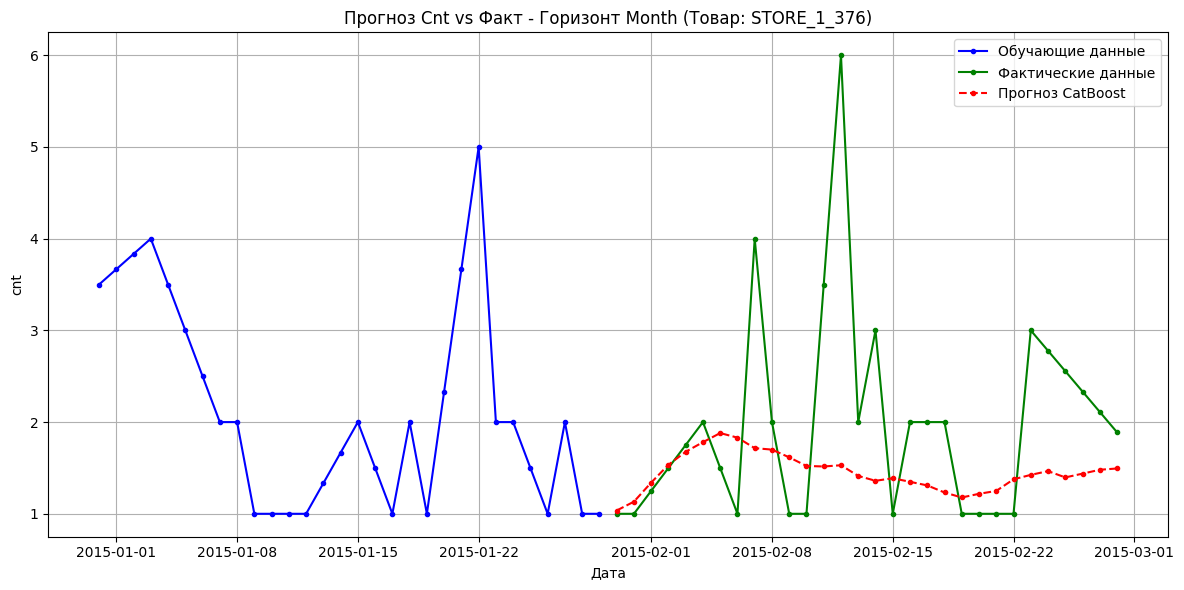

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_376...
Метрики оценки (горизонт quarter) для товара STORE_1_376:
  MAE:  0.87
  RMSE: 1.32
  MAPE: 35.62%
  R2:   -0.28


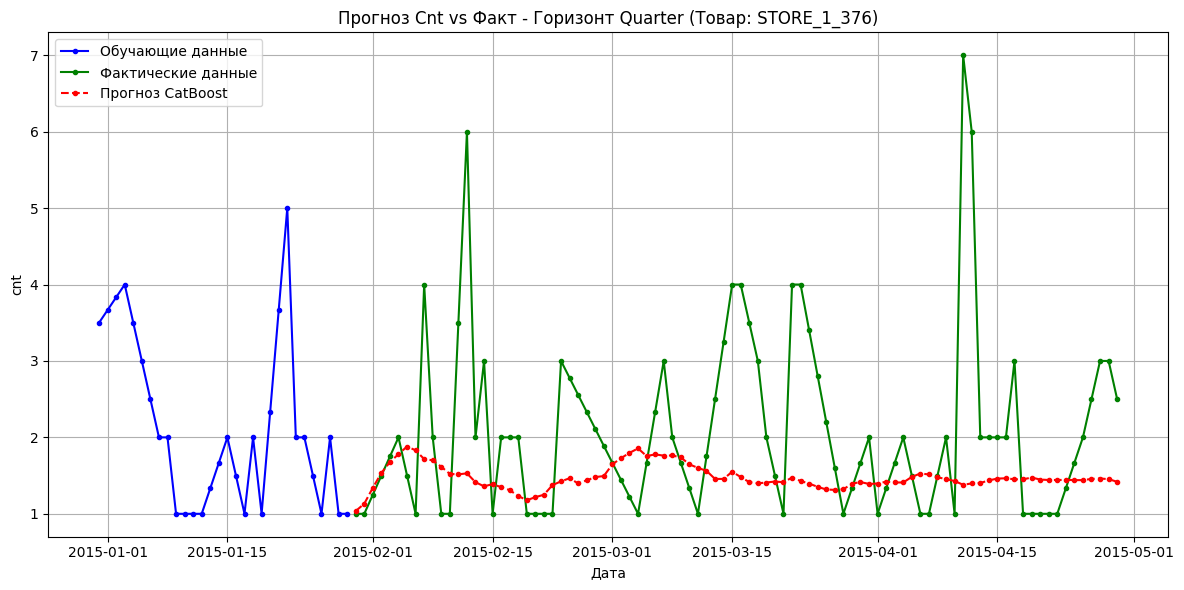


--- Итоговые результаты для товара STORE_1_376 ---
Horizon  MAE  RMSE  MAPE    R2
   week 0.14  0.18  9.54  0.73
  month 0.79  1.19 34.38 -0.17
quarter 0.87  1.32 35.62 -0.28
Модель сохранена: models\catboost_STORE_1_376_cnt_model.cbm

=== Прогнозирование по товару STORE_1_090 ===
Обучение модели CatBoost для cnt для товара STORE_1_090...

Топ-10 важных признаков для товара STORE_1_090:
                   Feature  Importance
        cnt_rolling_mean_7   12.380840
                 cnt_lag_1    9.369608
                 dayofweek    9.013928
cnt_rolling_mean_7_28_diff    7.287590
                 cnt_lag_7    6.589571
         cnt_rolling_std_7    5.582634
             dayofweek_sin    4.877502
                cnt_lag_14    3.393263
                 cnt_lag_3    3.184486
                       day    2.944564
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_090...
Метрики оценки (горизонт week) для товара STORE_1_090:
  MAE:  19.93
  RMSE: 22.28
  MAPE: 24.41%
  R2:   0.34

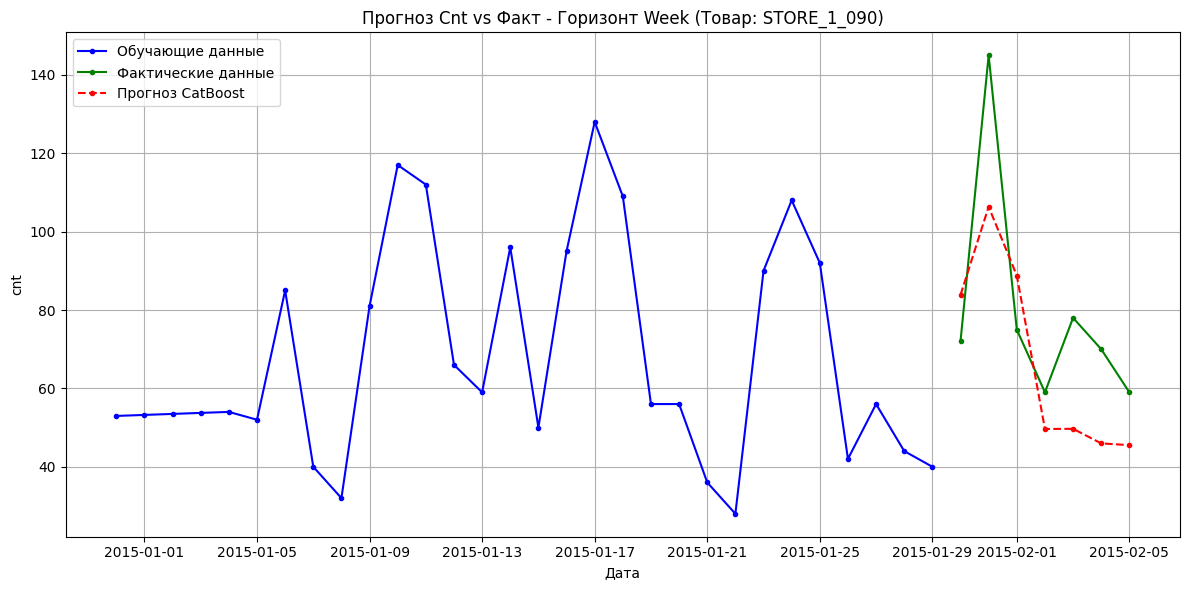

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_090...
Метрики оценки (горизонт month) для товара STORE_1_090:
  MAE:  20.20
  RMSE: 27.19
  MAPE: 36.61%
  R2:   -0.59


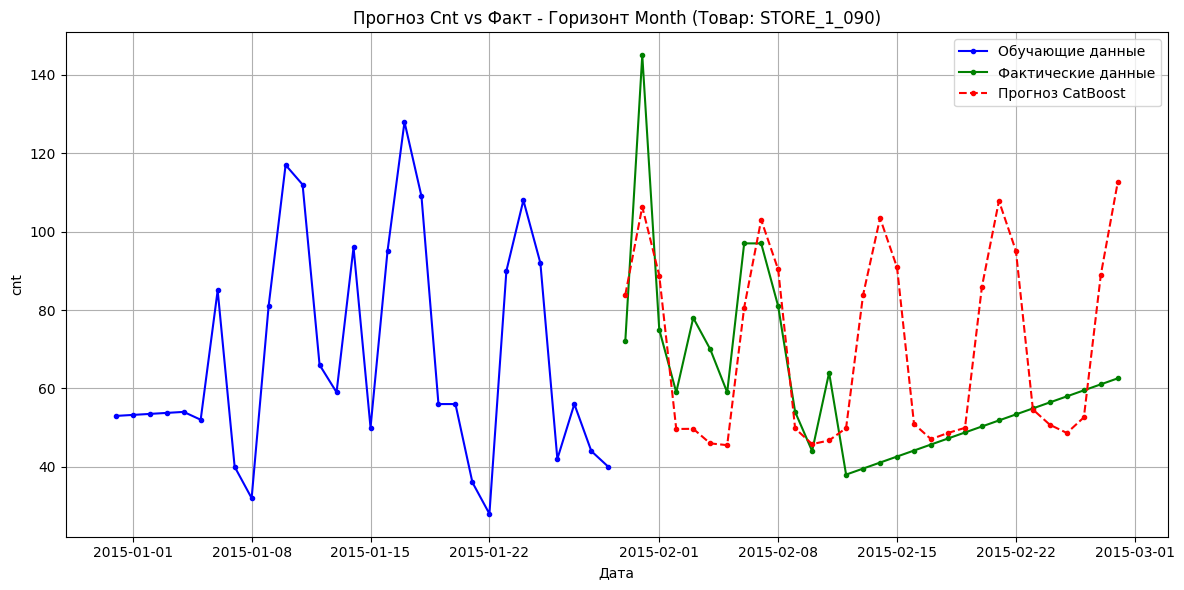

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_090...
Метрики оценки (горизонт quarter) для товара STORE_1_090:
  MAE:  19.23
  RMSE: 26.95
  MAPE: 86.90%
  R2:   -0.13


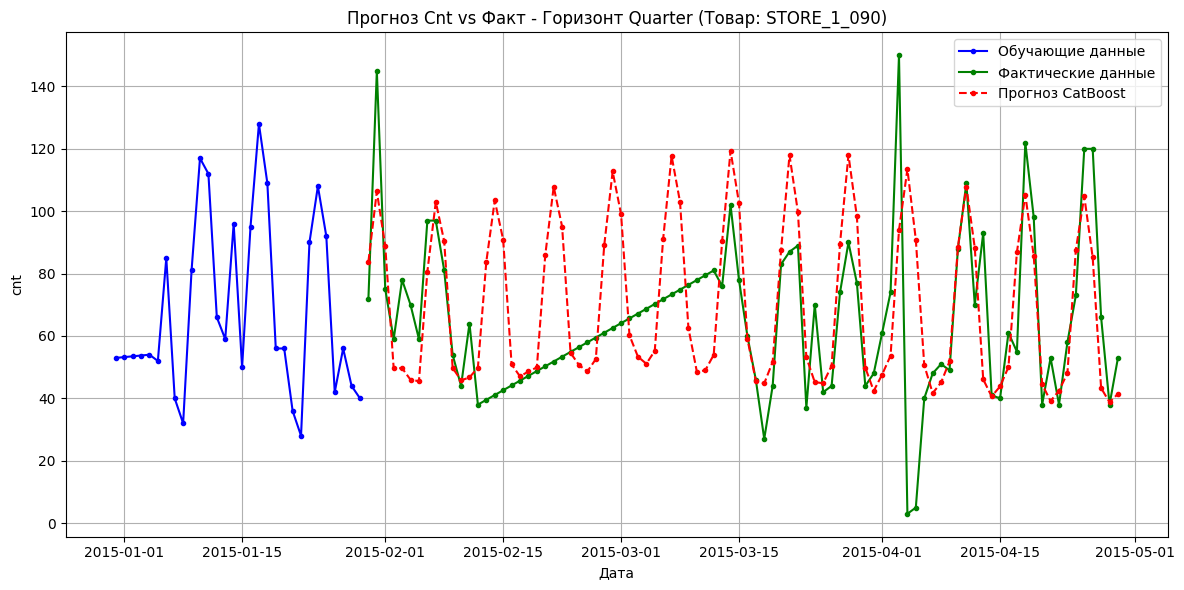


--- Итоговые результаты для товара STORE_1_090 ---
Horizon   MAE  RMSE  MAPE    R2
   week 19.93 22.28 24.41  0.34
  month 20.20 27.19 36.61 -0.59
quarter 19.23 26.95 86.90 -0.13
Модель сохранена: models\catboost_STORE_1_090_cnt_model.cbm

=== Прогнозирование по товару STORE_1_252 ===
Обучение модели CatBoost для cnt для товара STORE_1_252...

Топ-10 важных признаков для товара STORE_1_252:
                   Feature  Importance
        cnt_rolling_mean_7   16.423995
                 cnt_lag_1    6.109888
cnt_rolling_mean_7_28_diff    5.611618
             dayofweek_sin    4.891817
         cnt_rolling_std_7    4.584372
                       day    4.194736
                cnt_lag_28    4.062383
                 cnt_lag_3    3.942049
                 dayofweek    3.858185
                 cnt_lag_2    3.728150
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_252...
Метрики оценки (горизонт week) для товара STORE_1_252:
  MAE:  7.71
  RMSE: 7.87
  MAPE: 94.01%
  R2:   -1

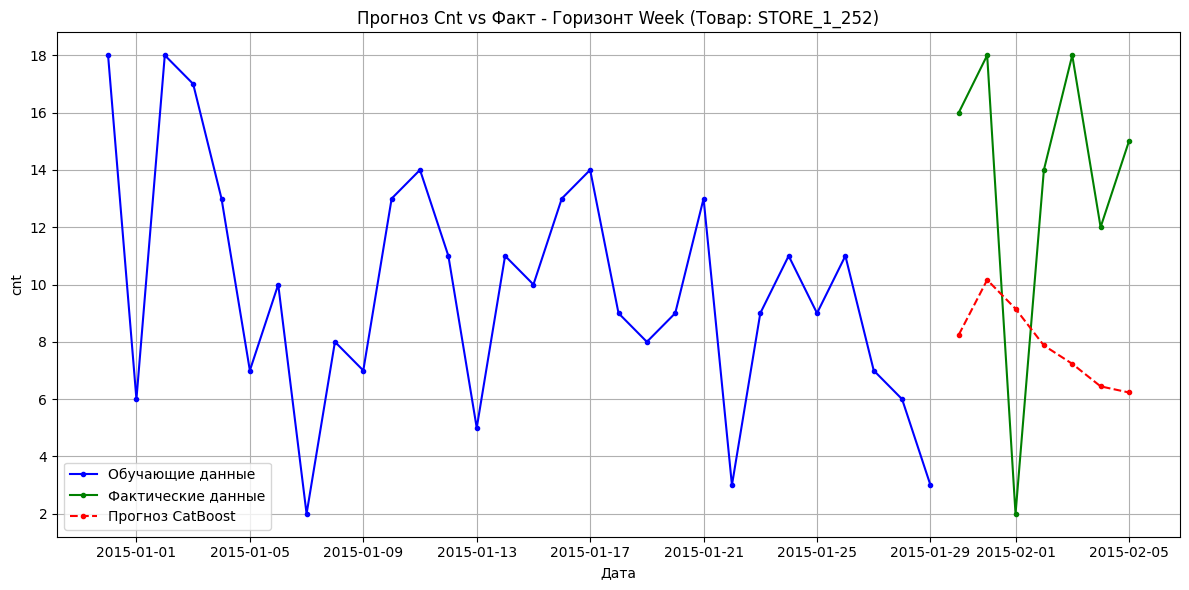

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_252...
Метрики оценки (горизонт month) для товара STORE_1_252:
  MAE:  6.62
  RMSE: 7.72
  MAPE: 49.42%
  R2:   -1.26


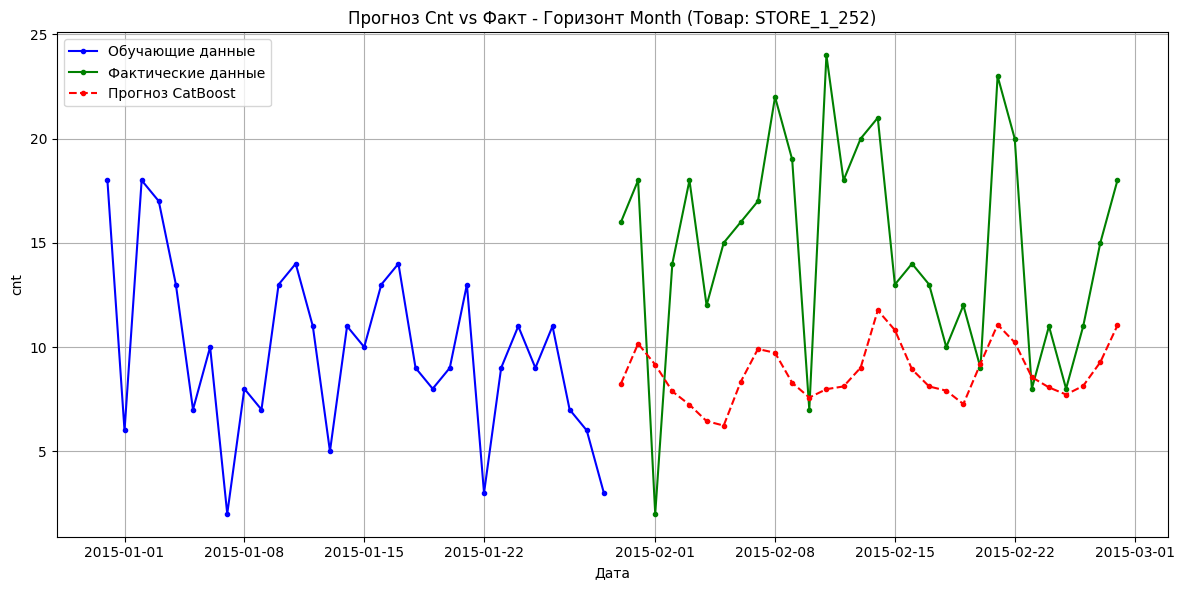

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_252...
Метрики оценки (горизонт quarter) для товара STORE_1_252:
  MAE:  5.78
  RMSE: 7.37
  MAPE: 41.46%
  R2:   -0.62


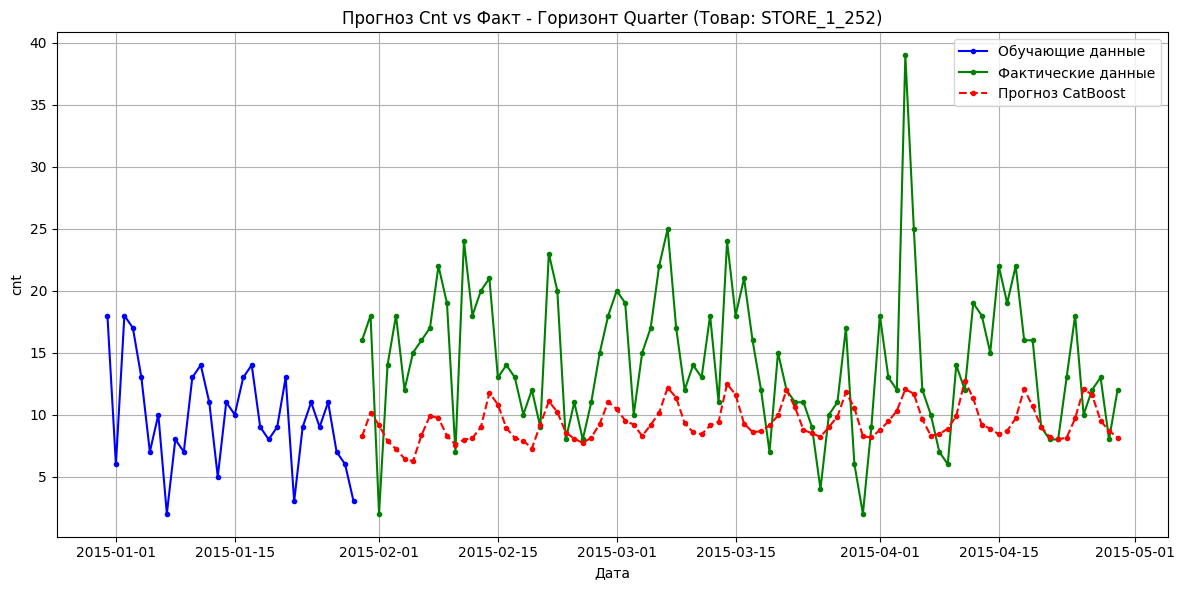


--- Итоговые результаты для товара STORE_1_252 ---
Horizon  MAE  RMSE  MAPE    R2
   week 7.71  7.87 94.01 -1.36
  month 6.62  7.72 49.42 -1.26
quarter 5.78  7.37 41.46 -0.62
Модель сохранена: models\catboost_STORE_1_252_cnt_model.cbm

=== Прогнозирование по товару STORE_1_339 ===
Обучение модели CatBoost для cnt для товара STORE_1_339...

Топ-10 важных признаков для товара STORE_1_339:
                   Feature  Importance
        cnt_rolling_mean_7   10.774331
cnt_rolling_mean_7_28_diff    9.002156
                 cnt_lag_1    7.287846
                 cnt_lag_3    5.378864
                 cnt_lag_2    5.018584
                cnt_lag_14    4.683738
         cnt_rolling_std_7    3.938208
       cnt_rolling_mean_28    3.669495
       cnt_rolling_mean_21    3.599244
       cnt_rolling_mean_14    3.096683
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_339...
Метрики оценки (горизонт week) для товара STORE_1_339:
  MAE:  1.59
  RMSE: 1.94
  MAPE: 37.44%
  R2:   -0.26


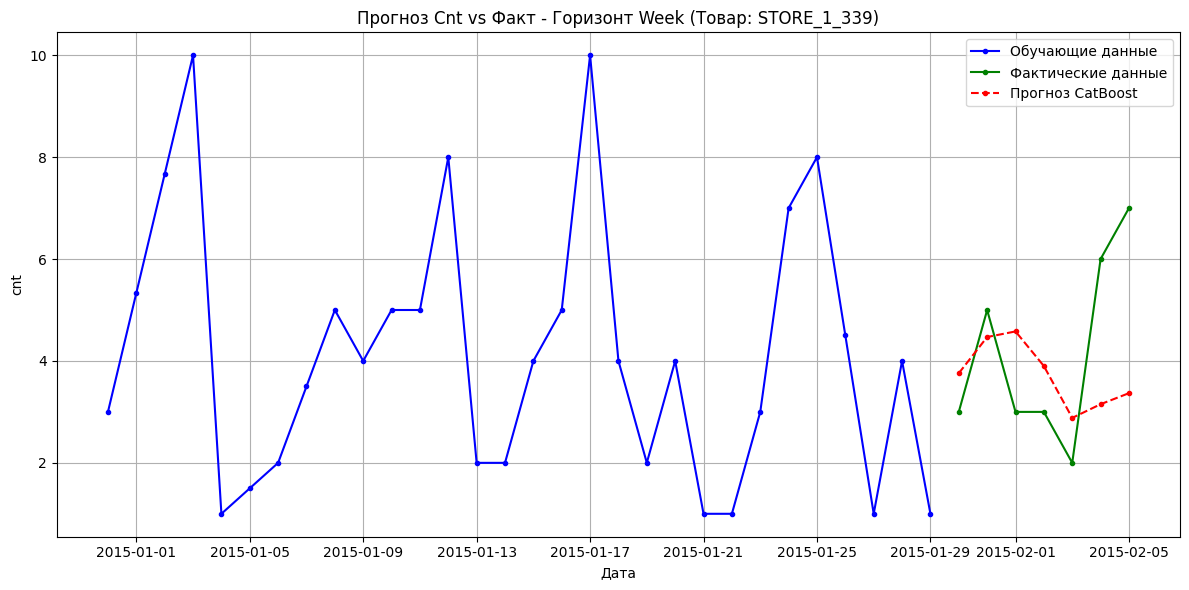

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_339...
Метрики оценки (горизонт month) для товара STORE_1_339:
  MAE:  2.23
  RMSE: 2.56
  MAPE: 92.52%
  R2:   -0.12


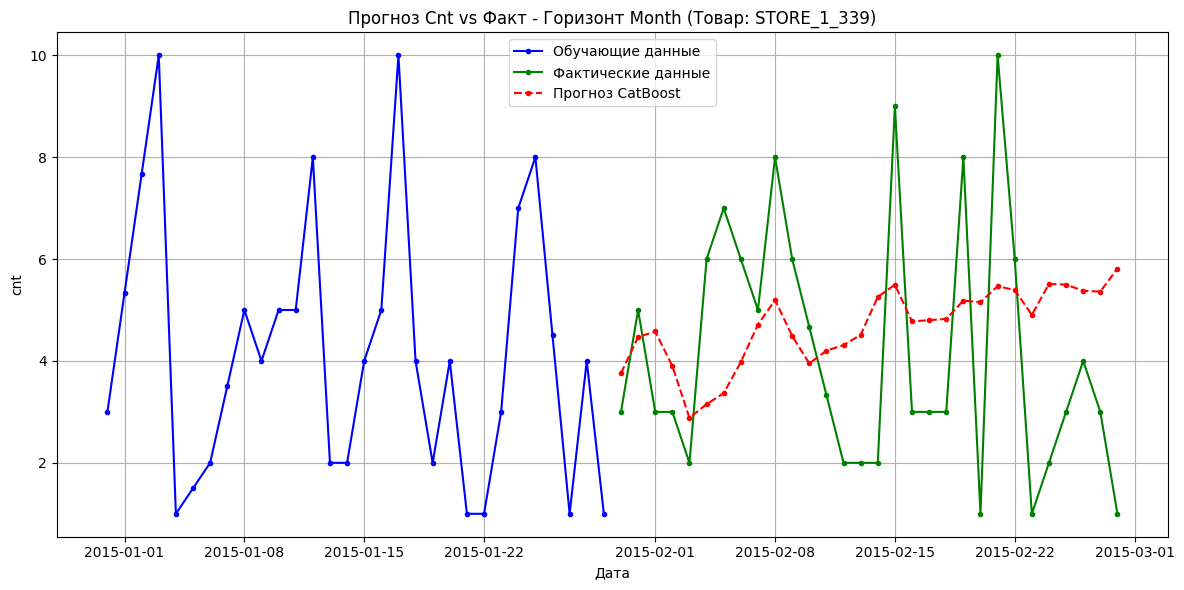

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_339...
Метрики оценки (горизонт quarter) для товара STORE_1_339:
  MAE:  2.55
  RMSE: 3.25
  MAPE: 112.62%
  R2:   -0.07


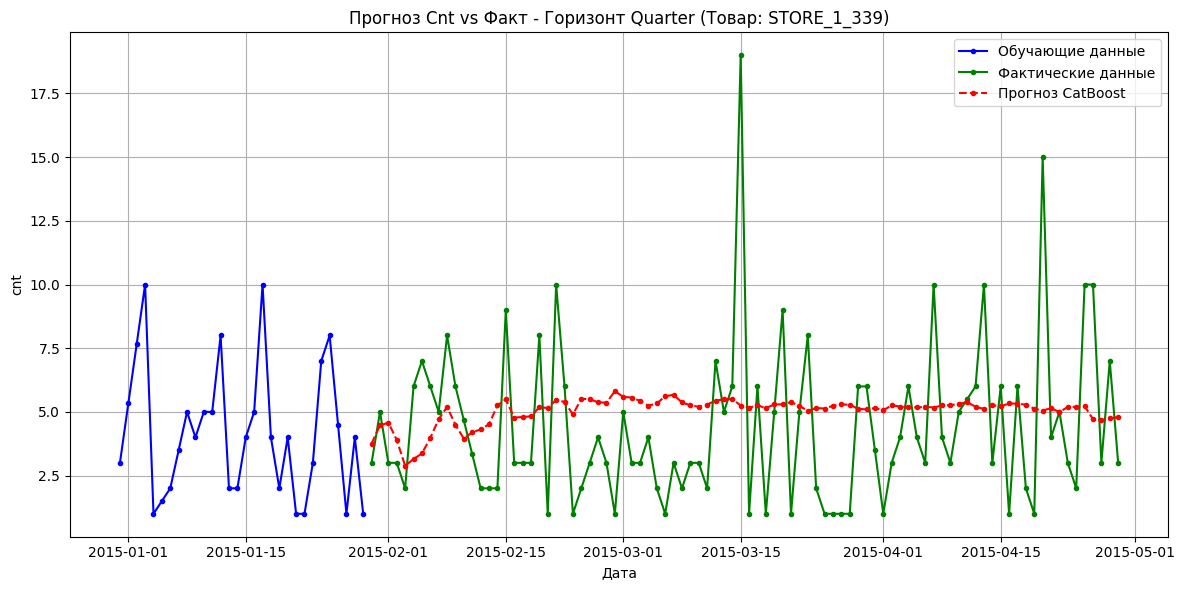


--- Итоговые результаты для товара STORE_1_339 ---
Horizon  MAE  RMSE   MAPE    R2
   week 1.59  1.94  37.44 -0.26
  month 2.23  2.56  92.52 -0.12
quarter 2.55  3.25 112.62 -0.07
Модель сохранена: models\catboost_STORE_1_339_cnt_model.cbm

=== Прогнозирование по товару STORE_1_546 ===
Обучение модели CatBoost для cnt для товара STORE_1_546...

Топ-10 важных признаков для товара STORE_1_546:
                   Feature  Importance
        cnt_rolling_mean_7   12.579230
cnt_rolling_mean_7_28_diff    9.035721
         cnt_rolling_std_7    6.856885
                 dayofweek    6.322450
                 cnt_lag_1    5.684352
             dayofweek_cos    3.612098
                 cnt_lag_3    3.572039
                 cnt_lag_2    3.457293
                cnt_lag_14    3.443802
       cnt_rolling_mean_14    3.312200
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_546...
Метрики оценки (горизонт week) для товара STORE_1_546:
  MAE:  0.70
  RMSE: 0.88
  MAPE: 41.19%
  R2:   -0

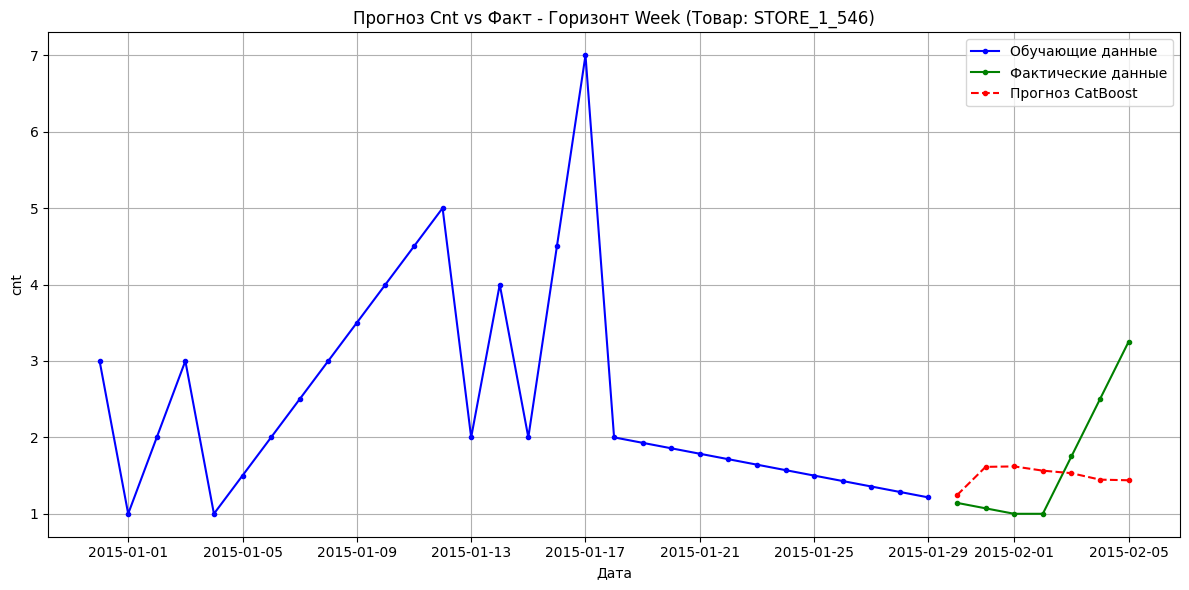

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_546...
Метрики оценки (горизонт month) для товара STORE_1_546:
  MAE:  1.38
  RMSE: 1.73
  MAPE: 58.50%
  R2:   -0.25


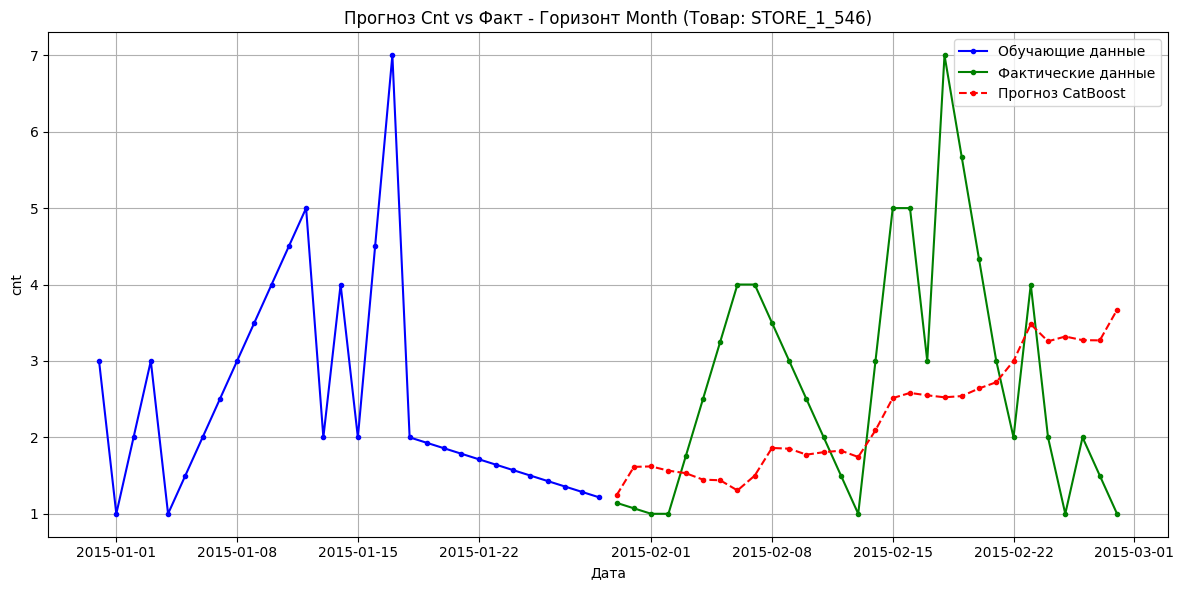

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_546...
Метрики оценки (горизонт quarter) для товара STORE_1_546:
  MAE:  1.74
  RMSE: 2.16
  MAPE: 67.89%
  R2:   0.10


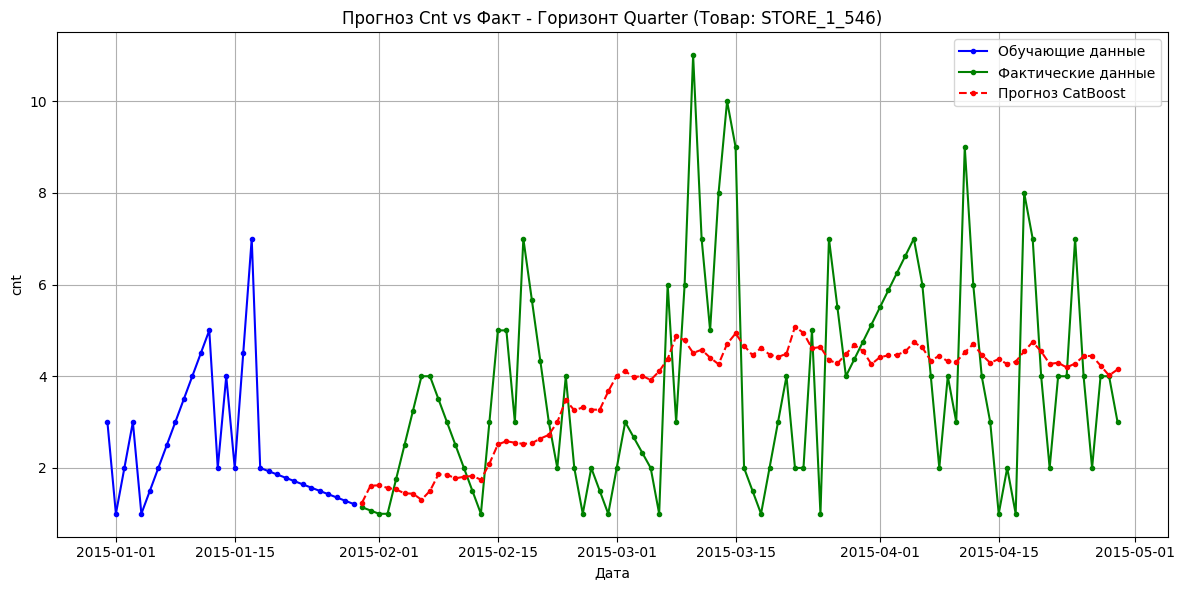


--- Итоговые результаты для товара STORE_1_546 ---
Horizon  MAE  RMSE  MAPE    R2
   week 0.70  0.88 41.19 -0.15
  month 1.38  1.73 58.50 -0.25
quarter 1.74  2.16 67.89  0.10
Модель сохранена: models\catboost_STORE_1_546_cnt_model.cbm

=== Прогнозирование по товару STORE_1_547 ===
Обучение модели CatBoost для cnt для товара STORE_1_547...

Топ-10 важных признаков для товара STORE_1_547:
                   Feature  Importance
        cnt_rolling_mean_7   13.258684
                 cnt_lag_1    8.624880
          CASHBACK_STORE_1    7.666881
cnt_rolling_mean_7_28_diff    7.266276
                 cnt_lag_2    7.244621
                 cnt_lag_3    4.029092
                       day    3.969818
         cnt_rolling_std_7    3.950260
                cnt_lag_35    3.144270
                cnt_lag_14    2.877092
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_547...
Метрики оценки (горизонт week) для товара STORE_1_547:
  MAE:  3.54
  RMSE: 3.72
  MAPE: 27.80%
  R2:   -0.86


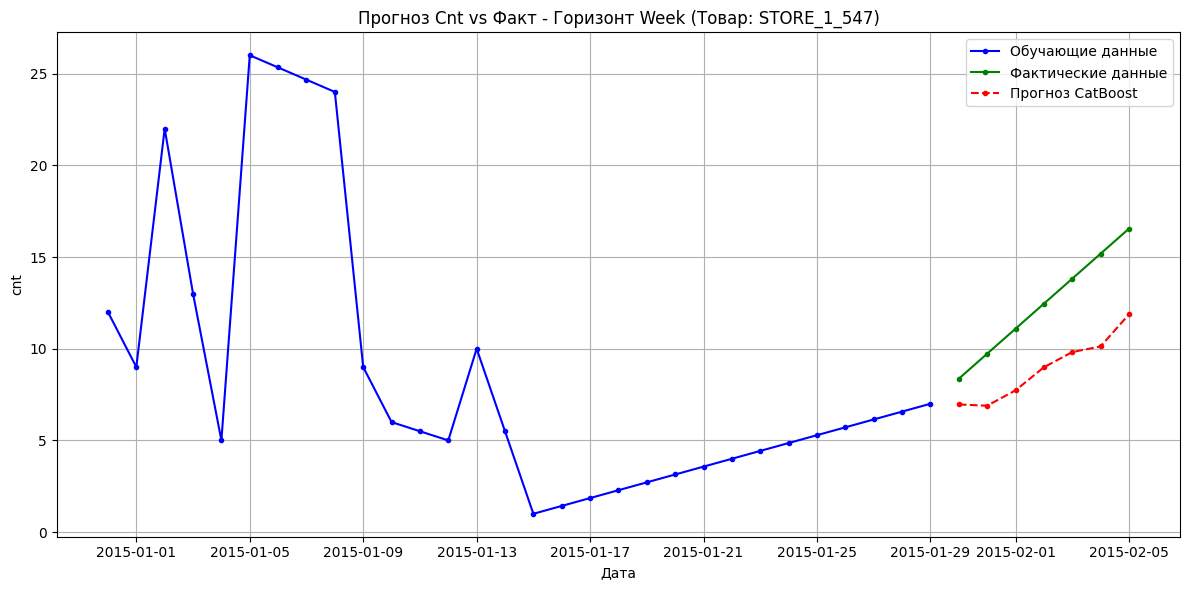

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_547...
Метрики оценки (горизонт month) для товара STORE_1_547:
  MAE:  5.20
  RMSE: 6.47
  MAPE: 43.55%
  R2:   0.04


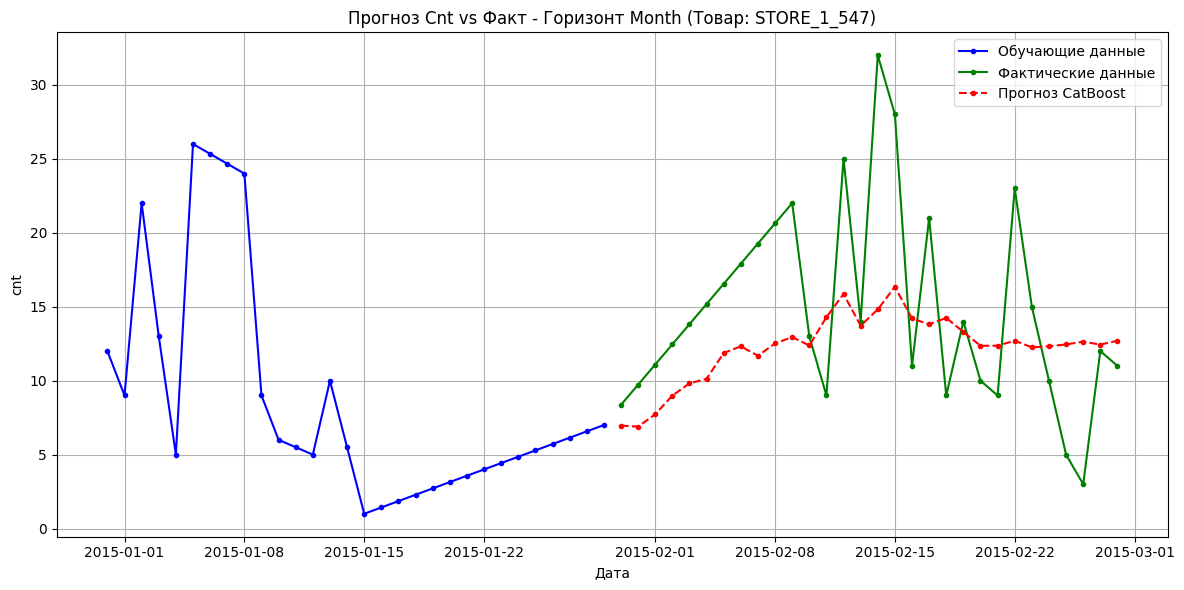

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_547...
Метрики оценки (горизонт quarter) для товара STORE_1_547:
  MAE:  6.34
  RMSE: 9.68
  MAPE: 74.89%
  R2:   0.04


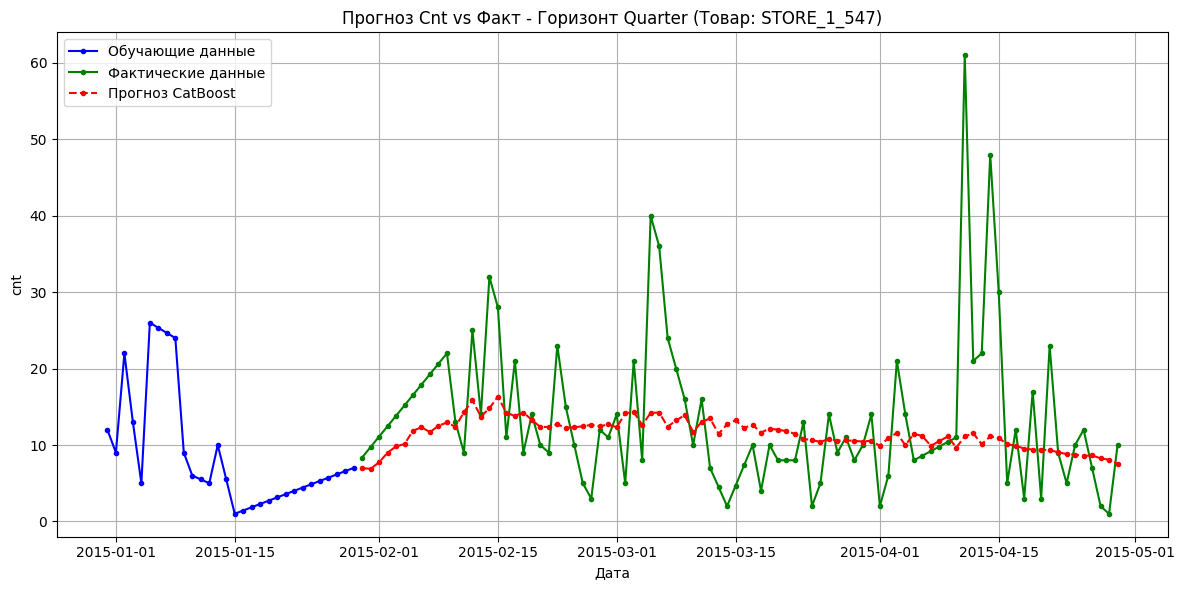


--- Итоговые результаты для товара STORE_1_547 ---
Horizon  MAE  RMSE  MAPE    R2
   week 3.54  3.72 27.80 -0.86
  month 5.20  6.47 43.55  0.04
quarter 6.34  9.68 74.89  0.04
Модель сохранена: models\catboost_STORE_1_547_cnt_model.cbm

=== Прогнозирование по товару STORE_1_555 ===
Обучение модели CatBoost для cnt для товара STORE_1_555...

Топ-10 важных признаков для товара STORE_1_555:
                   Feature  Importance
        cnt_rolling_mean_7   17.020474
                 dayofweek    7.536352
             dayofweek_sin    7.178163
                       day    5.018621
cnt_rolling_mean_7_28_diff    4.850883
         cnt_rolling_std_7    4.542426
       cnt_rolling_mean_14    4.131665
                 cnt_lag_1    3.959852
                cnt_lag_28    3.299577
                      year    2.877411
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_555...
Метрики оценки (горизонт week) для товара STORE_1_555:
  MAE:  5.10
  RMSE: 5.48
  MAPE: 33.68%
  R2:   0.34


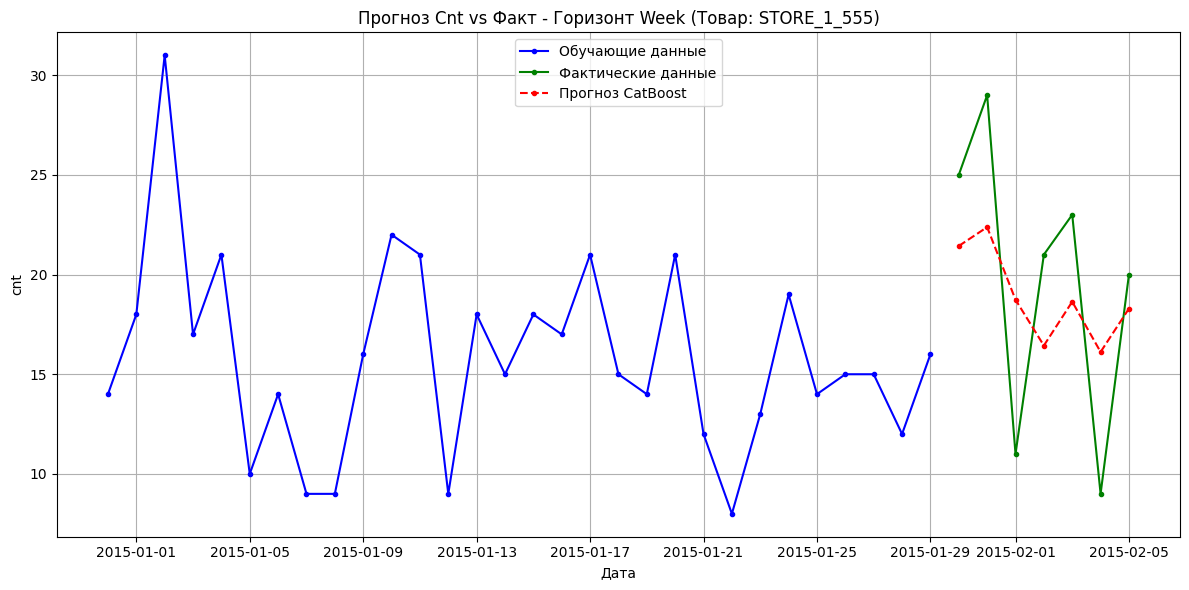

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_555...
Метрики оценки (горизонт month) для товара STORE_1_555:
  MAE:  5.98
  RMSE: 7.42
  MAPE: 26.63%
  R2:   0.00


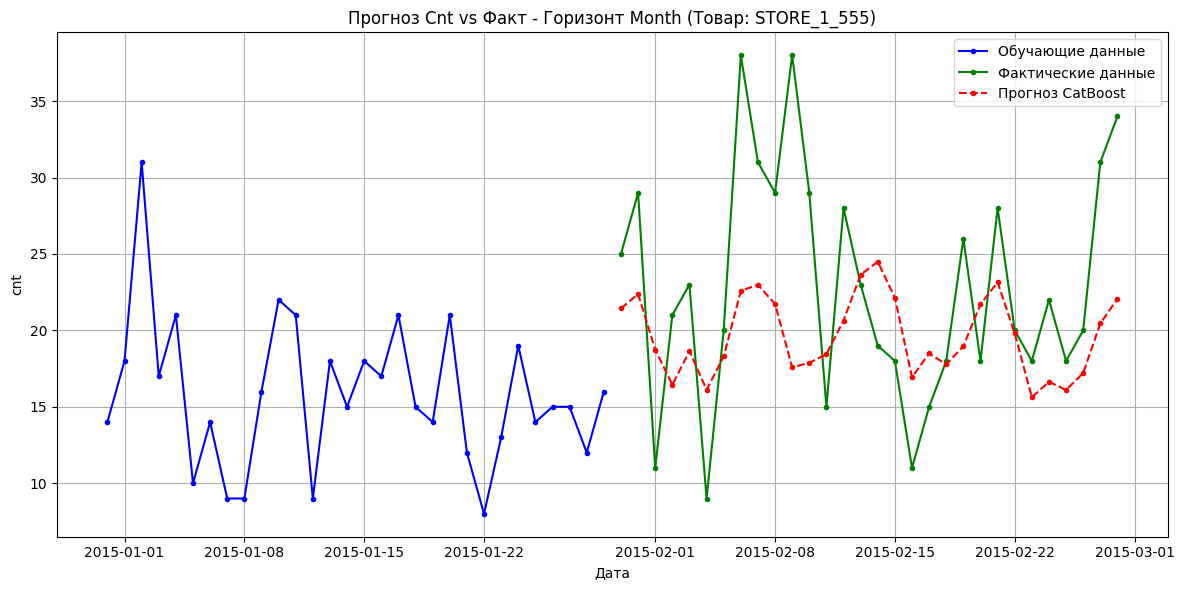

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_555...
Метрики оценки (горизонт quarter) для товара STORE_1_555:
  MAE:  4.93
  RMSE: 6.21
  MAPE: 27.83%
  R2:   0.23


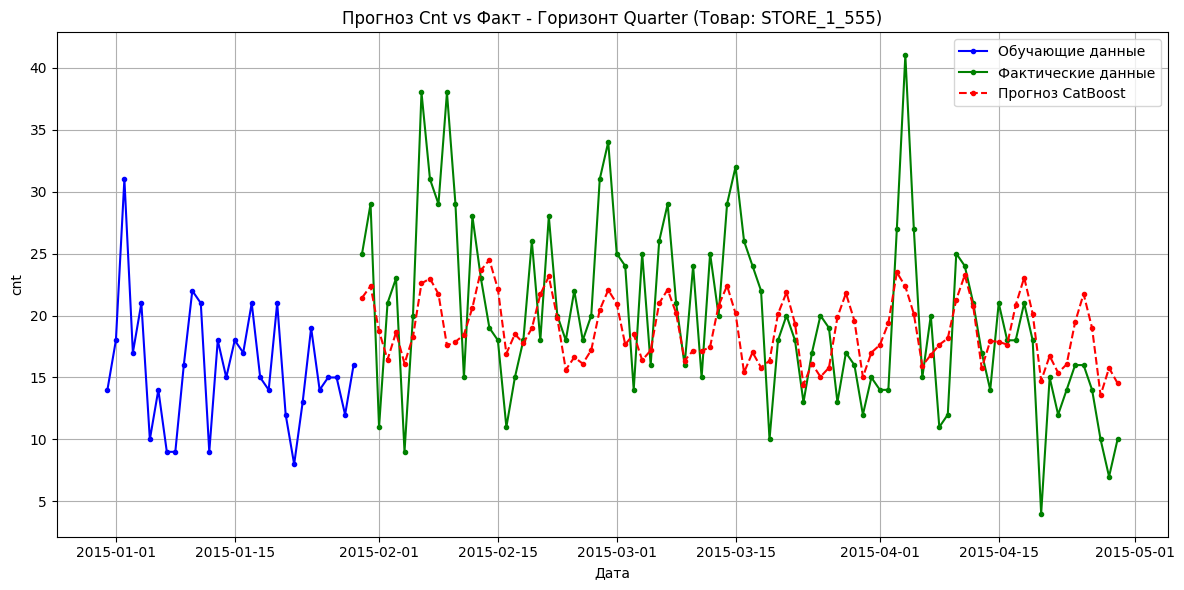


--- Итоговые результаты для товара STORE_1_555 ---
Horizon  MAE  RMSE  MAPE   R2
   week 5.10  5.48 33.68 0.34
  month 5.98  7.42 26.63 0.00
quarter 4.93  6.21 27.83 0.23
Модель сохранена: models\catboost_STORE_1_555_cnt_model.cbm

=== Прогнозирование по товару STORE_1_584 ===
Обучение модели CatBoost для cnt для товара STORE_1_584...

Топ-10 важных признаков для товара STORE_1_584:
                   Feature  Importance
        cnt_rolling_mean_7   18.322337
                 cnt_lag_1    7.770065
         cnt_rolling_std_7    6.159957
                       day    5.357059
cnt_rolling_mean_7_28_diff    4.776158
                      year    3.391903
                cnt_lag_28    3.327113
                 cnt_lag_7    3.301148
                 cnt_lag_3    3.299470
                 cnt_lag_2    3.144313
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_584...
Метрики оценки (горизонт week) для товара STORE_1_584:
  MAE:  2.73
  RMSE: 4.00
  MAPE: 64.49%
  R2:   -0.46


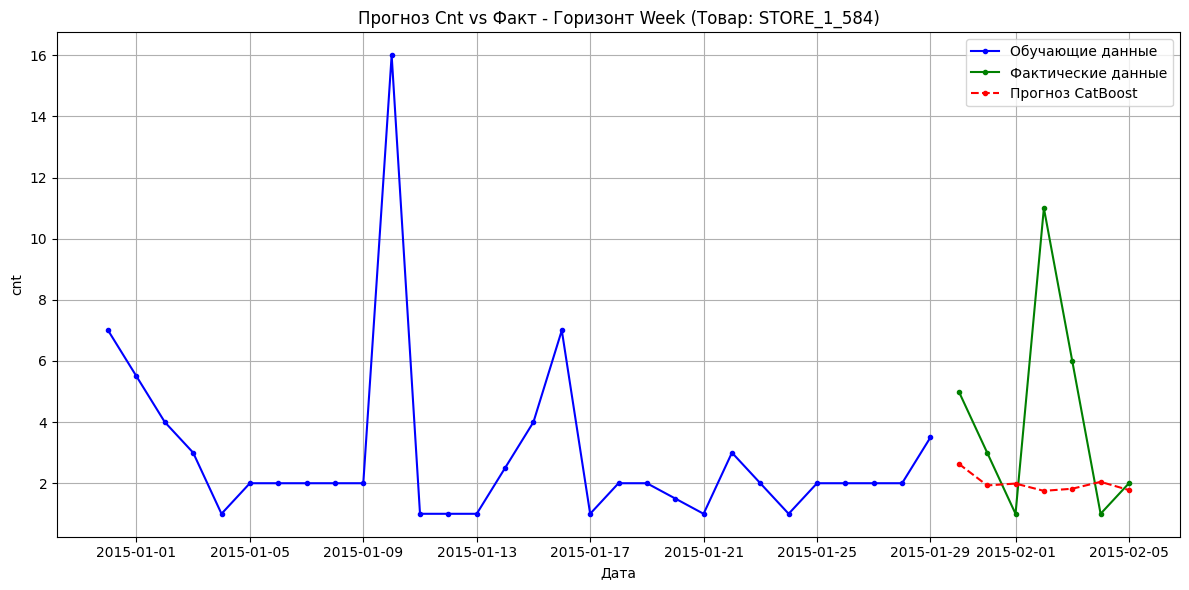

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_584...
Метрики оценки (горизонт month) для товара STORE_1_584:
  MAE:  1.68
  RMSE: 2.58
  MAPE: 60.24%
  R2:   -0.17


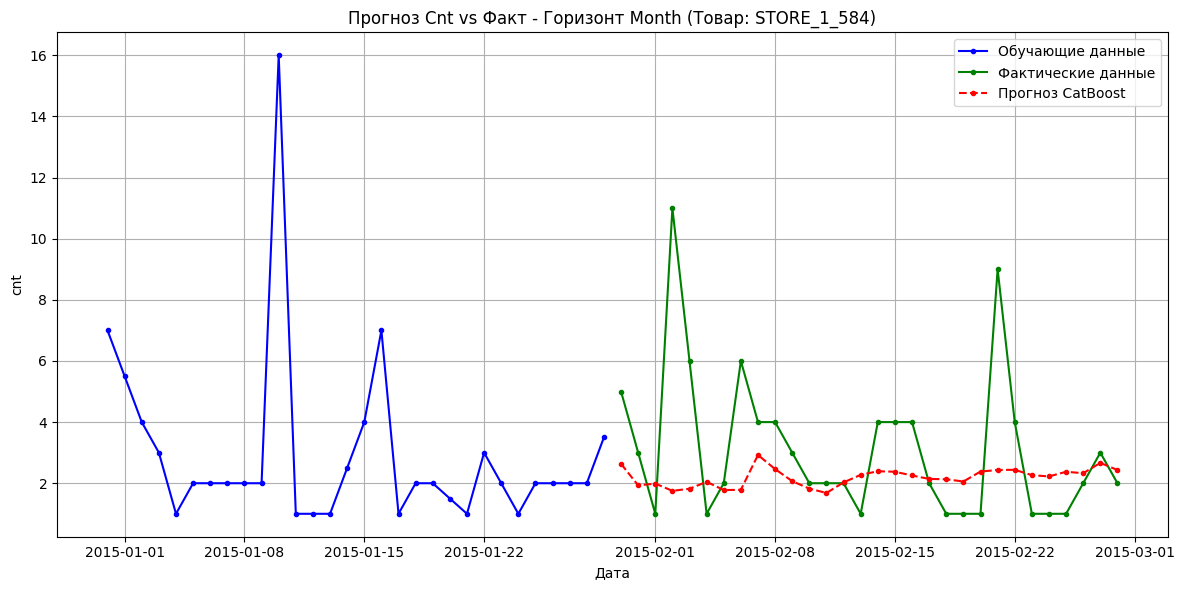

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_584...
Метрики оценки (горизонт quarter) для товара STORE_1_584:
  MAE:  2.38
  RMSE: 2.90
  MAPE: 132.56%
  R2:   -1.55


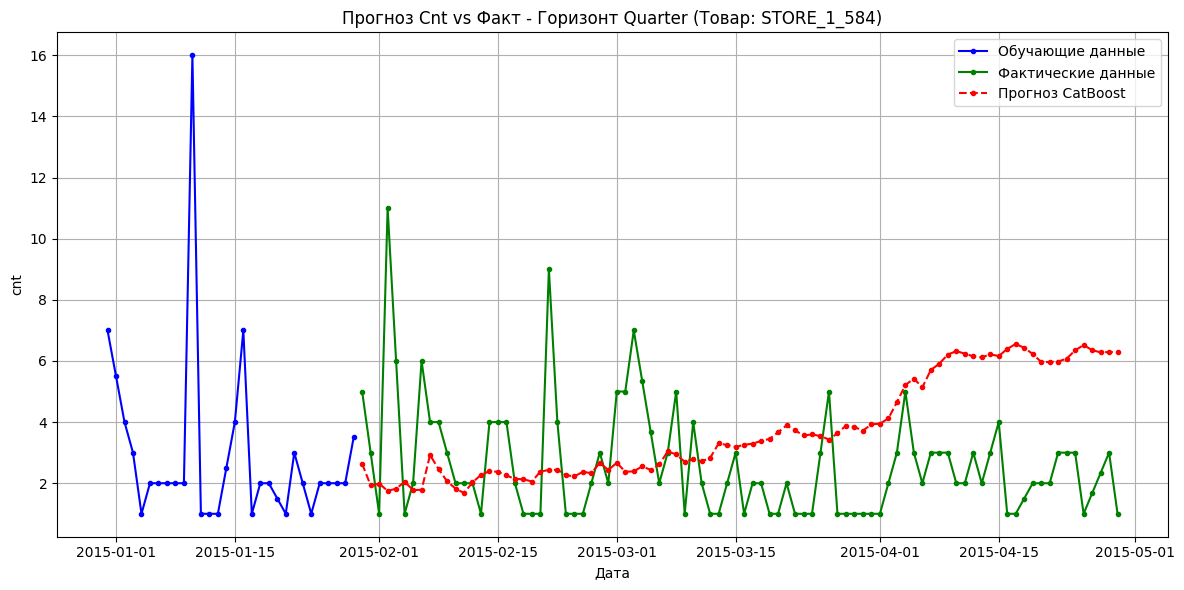


--- Итоговые результаты для товара STORE_1_584 ---
Horizon  MAE  RMSE   MAPE    R2
   week 2.73  4.00  64.49 -0.46
  month 1.68  2.58  60.24 -0.17
quarter 2.38  2.90 132.56 -1.55
Модель сохранена: models\catboost_STORE_1_584_cnt_model.cbm

=== Прогнозирование по товару STORE_1_586 ===
Обучение модели CatBoost для cnt для товара STORE_1_586...

Топ-10 важных признаков для товара STORE_1_586:
                   Feature  Importance
        cnt_rolling_mean_7   14.939687
       cnt_rolling_mean_28    8.091539
             dayofweek_sin    7.604548
                 dayofweek    7.436640
       cnt_rolling_mean_14    5.432094
cnt_rolling_mean_7_28_diff    4.987919
         cnt_rolling_std_7    4.257703
                cnt_lag_28    3.786306
                       day    3.706678
                 cnt_lag_1    3.538842
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_586...
Метрики оценки (горизонт week) для товара STORE_1_586:
  MAE:  8.96
  RMSE: 10.65
  MAPE: 26.08%
  R2:   -

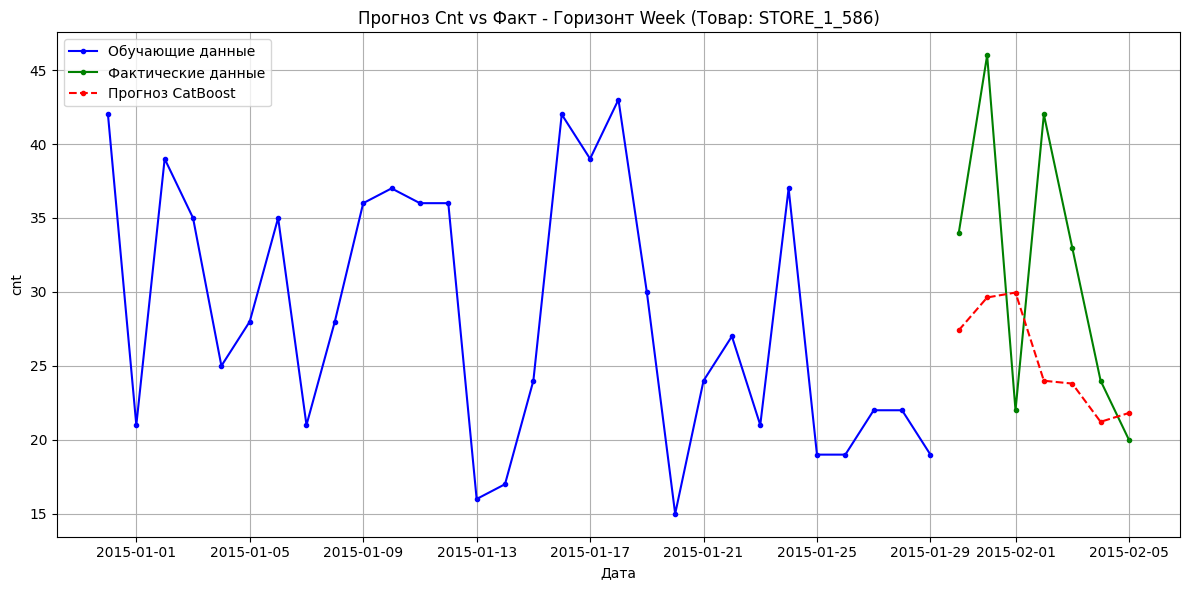

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_586...
Метрики оценки (горизонт month) для товара STORE_1_586:
  MAE:  8.82
  RMSE: 10.51
  MAPE: 26.16%
  R2:   -0.07


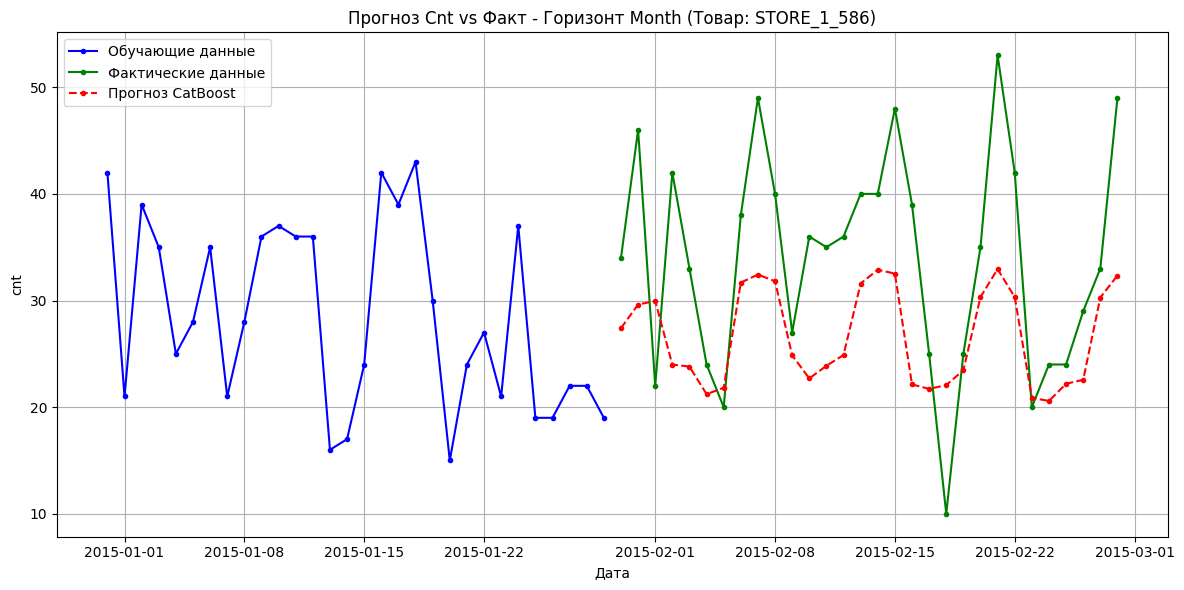

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_586...
Метрики оценки (горизонт quarter) для товара STORE_1_586:
  MAE:  6.70
  RMSE: 8.44
  MAPE: 23.04%
  R2:   0.22


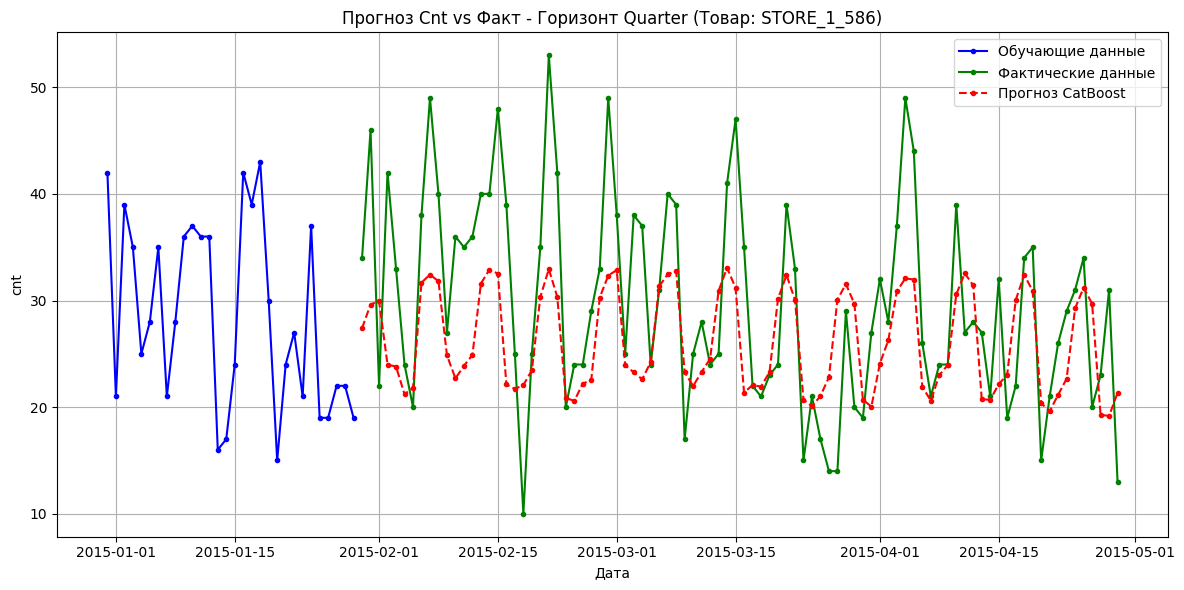


--- Итоговые результаты для товара STORE_1_586 ---
Horizon  MAE  RMSE  MAPE    R2
   week 8.96 10.65 26.08 -0.31
  month 8.82 10.51 26.16 -0.07
quarter 6.70  8.44 23.04  0.22
Модель сохранена: models\catboost_STORE_1_586_cnt_model.cbm

=== Прогнозирование по товару STORE_1_587 ===
Обучение модели CatBoost для cnt для товара STORE_1_587...

Топ-10 важных признаков для товара STORE_1_587:
                   Feature  Importance
        cnt_rolling_mean_7   21.232138
                 cnt_lag_1    8.381416
cnt_rolling_mean_7_28_diff    5.813758
         cnt_rolling_std_7    4.669671
                       day    3.960120
       cnt_rolling_mean_14    3.536304
             dayofweek_sin    3.502869
                      year    3.378746
                 cnt_lag_2    3.321359
                 cnt_lag_7    3.024662
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_587...
Метрики оценки (горизонт week) для товара STORE_1_587:
  MAE:  8.18
  RMSE: 9.25
  MAPE: 32.70%
  R2:   -1.80


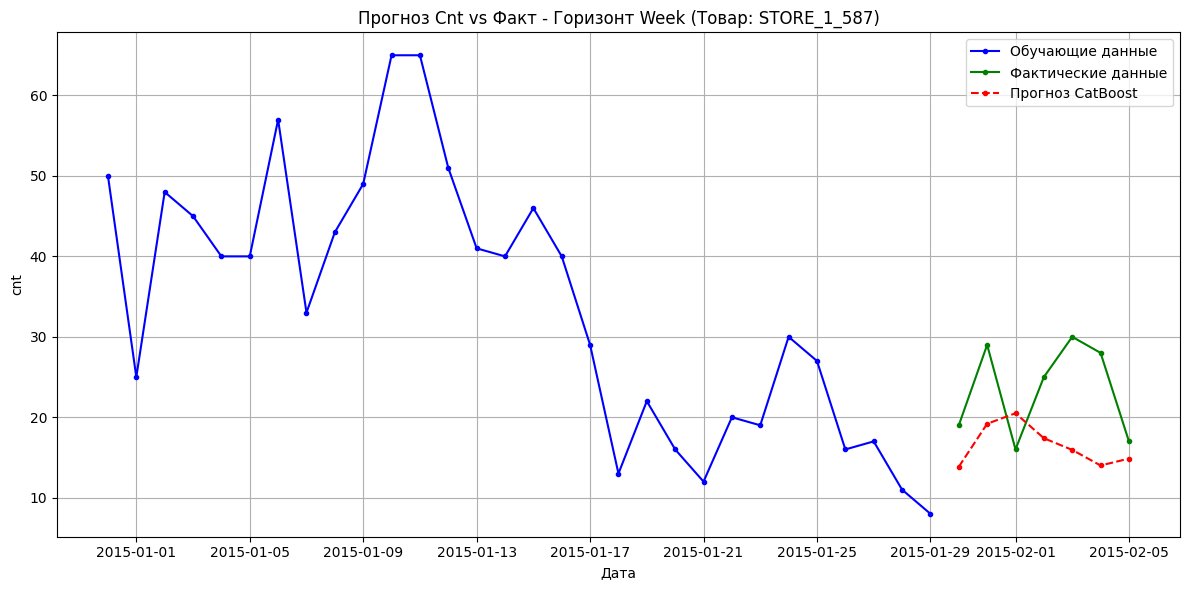

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_587...
Метрики оценки (горизонт month) для товара STORE_1_587:
  MAE:  9.66
  RMSE: 12.28
  MAPE: 34.23%
  R2:   -1.13


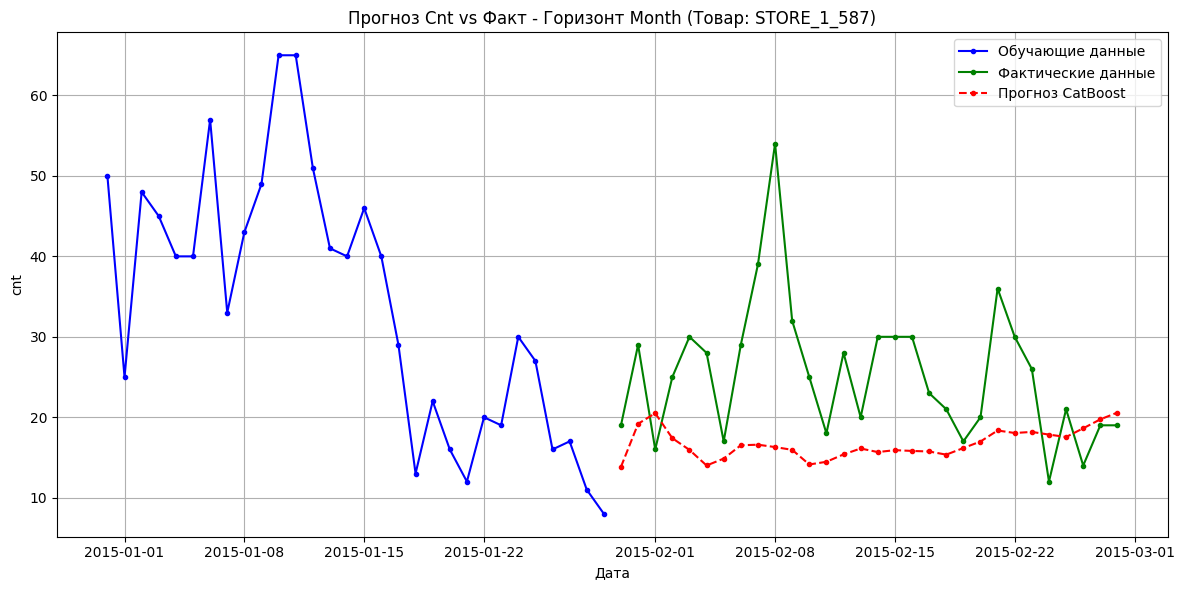

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_587...
Метрики оценки (горизонт quarter) для товара STORE_1_587:
  MAE:  10.24
  RMSE: 12.90
  MAPE: 31.79%
  R2:   -0.86


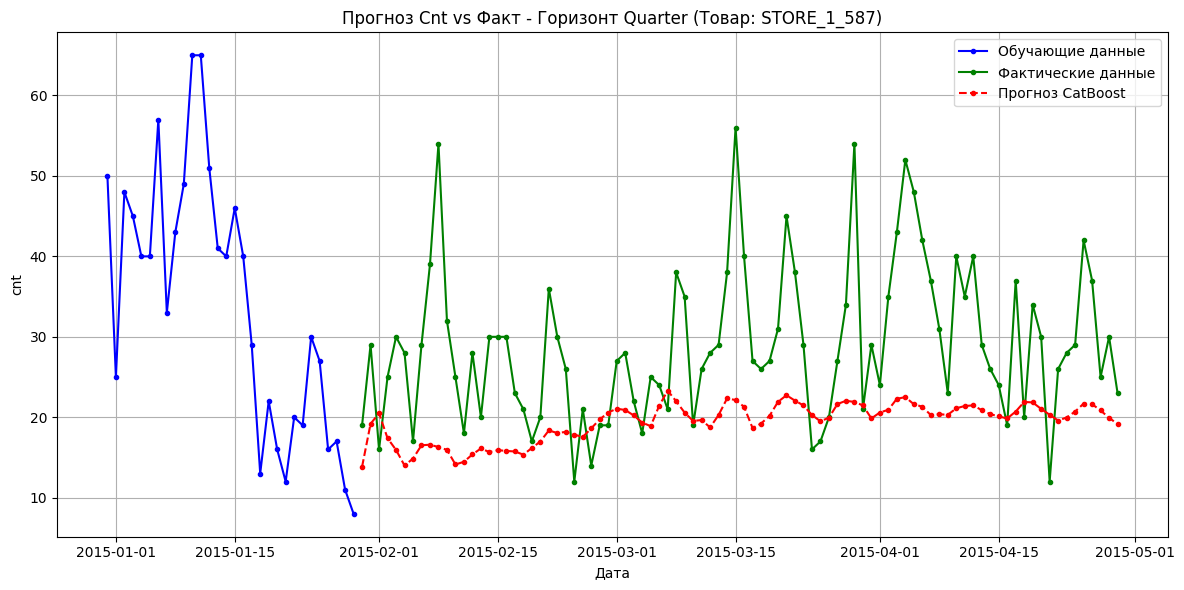


--- Итоговые результаты для товара STORE_1_587 ---
Horizon   MAE  RMSE  MAPE    R2
   week  8.18  9.25 32.70 -1.80
  month  9.66 12.28 34.23 -1.13
quarter 10.24 12.90 31.79 -0.86
Модель сохранена: models\catboost_STORE_1_587_cnt_model.cbm

=== Прогнозирование по товару STORE_1_714 ===
Обучение модели CatBoost для cnt для товара STORE_1_714...

Топ-10 важных признаков для товара STORE_1_714:
                   Feature  Importance
        cnt_rolling_mean_7   14.503796
                 dayofweek    8.287324
                       day    5.708856
                 cnt_lag_1    5.371496
cnt_rolling_mean_7_28_diff    5.280739
       cnt_rolling_mean_14    4.694217
             dayofweek_sin    3.721621
                 cnt_lag_3    3.325839
       cnt_rolling_mean_21    3.142946
                cnt_lag_28    3.077435
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_714...
Метрики оценки (горизонт week) для товара STORE_1_714:
  MAE:  8.50
  RMSE: 10.87
  MAPE: 47.30%
  R2:   0

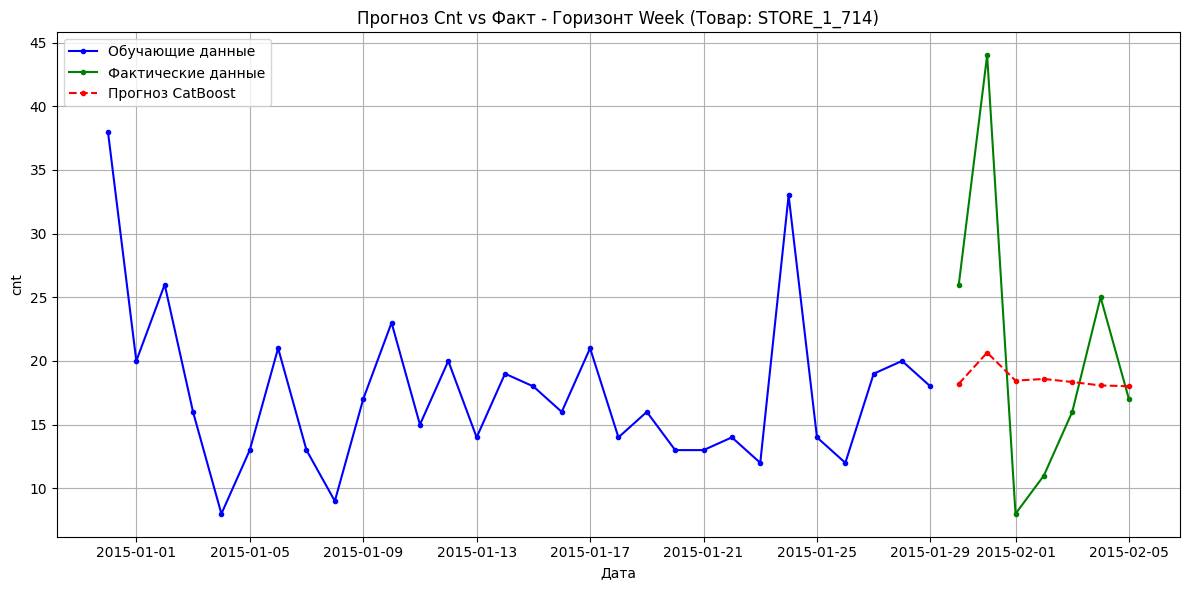

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_714...
Метрики оценки (горизонт month) для товара STORE_1_714:
  MAE:  6.22
  RMSE: 7.77
  MAPE: 34.76%
  R2:   0.15


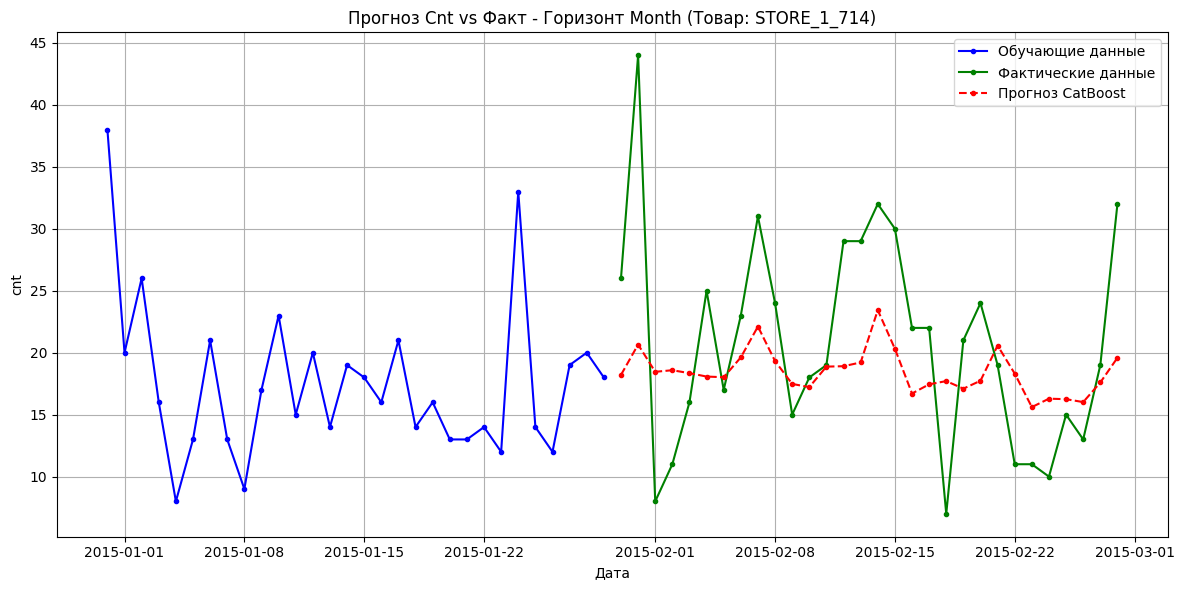

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_714...
Метрики оценки (горизонт quarter) для товара STORE_1_714:
  MAE:  5.13
  RMSE: 6.68
  MAPE: 30.21%
  R2:   0.13


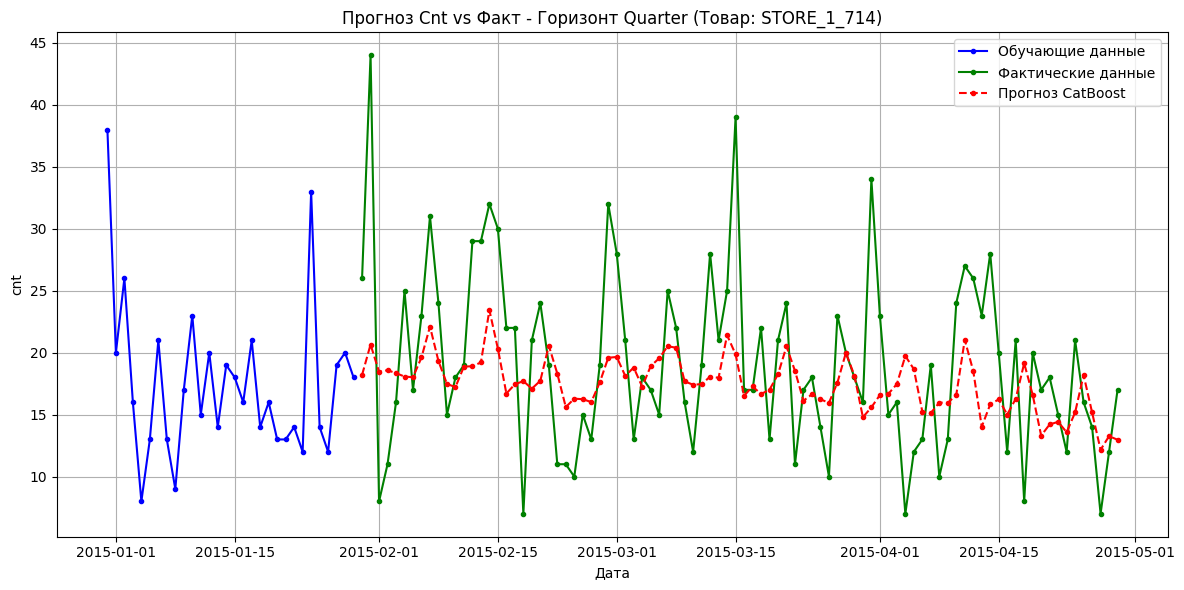


--- Итоговые результаты для товара STORE_1_714 ---
Horizon  MAE  RMSE  MAPE   R2
   week 8.50 10.87 47.30 0.06
  month 6.22  7.77 34.76 0.15
quarter 5.13  6.68 30.21 0.13
Модель сохранена: models\catboost_STORE_1_714_cnt_model.cbm

=== Прогнозирование по товару STORE_1_727 ===
Обучение модели CatBoost для cnt для товара STORE_1_727...

Топ-10 важных признаков для товара STORE_1_727:
                   Feature  Importance
        cnt_rolling_mean_7   15.775866
cnt_rolling_mean_7_28_diff    8.877981
       cnt_rolling_mean_14    4.666319
                 cnt_lag_1    4.635127
                 cnt_lag_3    4.469988
         cnt_rolling_std_7    4.395108
                 cnt_lag_7    4.203375
                is_weekend    3.289098
                 dayofweek    3.215005
                 cnt_lag_2    2.864063
Генерация прогноза на week (7 дней) для cnt для товара STORE_1_727...
Метрики оценки (горизонт week) для товара STORE_1_727:
  MAE:  1.83
  RMSE: 2.37
  MAPE: 39.50%
  R2:   -3.38


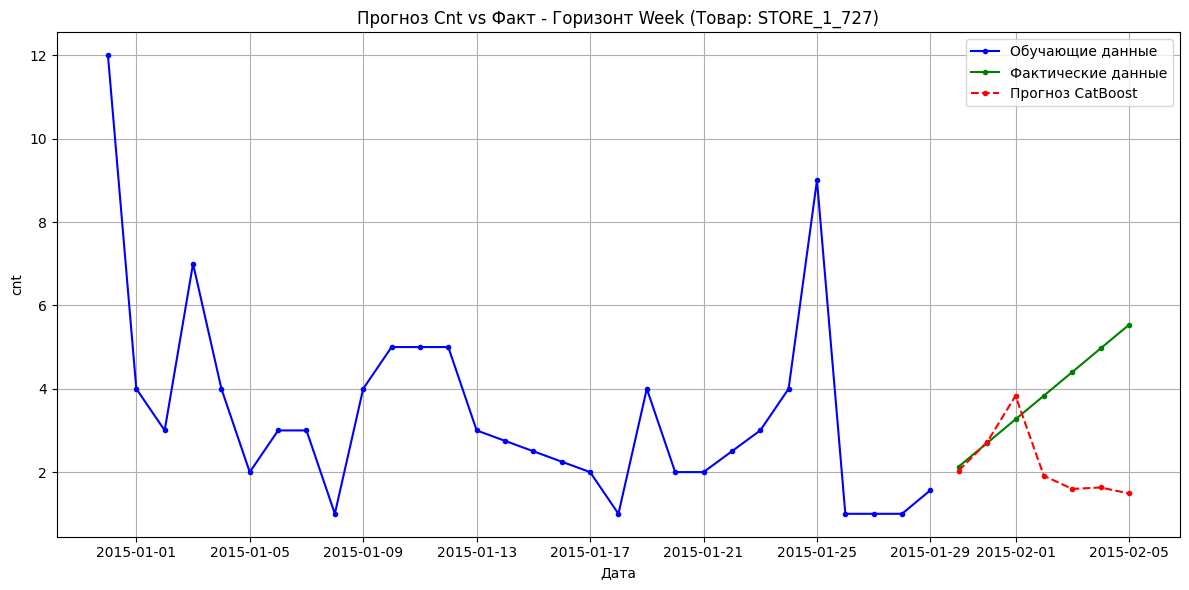

Генерация прогноза на month (30 дней) для cnt для товара STORE_1_727...
Метрики оценки (горизонт month) для товара STORE_1_727:
  MAE:  8.01
  RMSE: 9.28
  MAPE: 71.26%
  R2:   -2.97


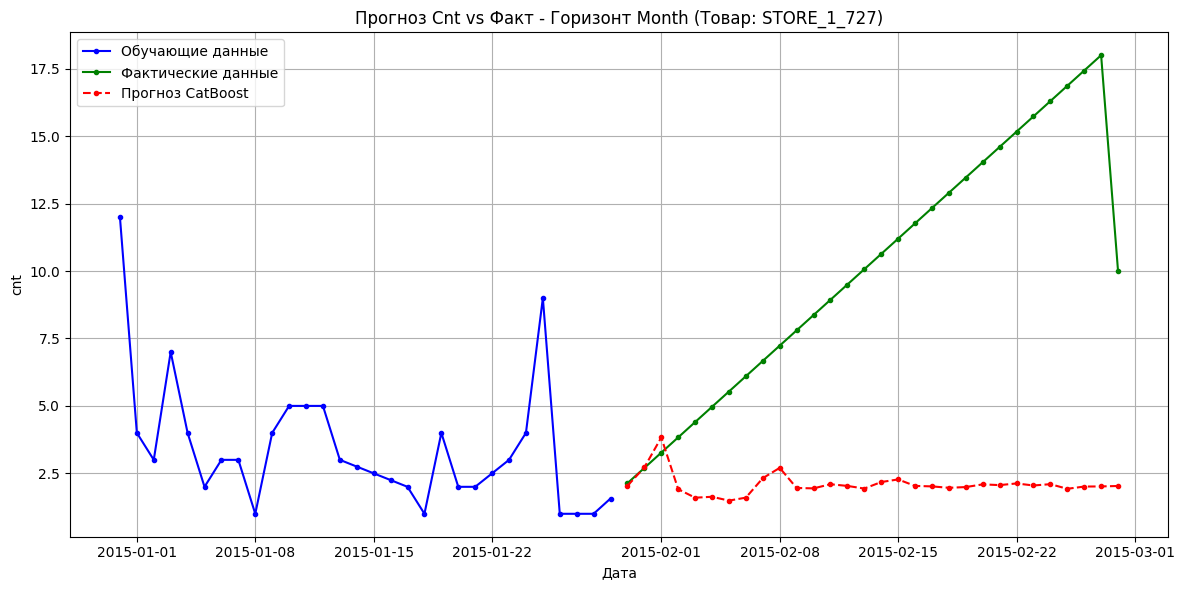

Генерация прогноза на quarter (90 дней) для cnt для товара STORE_1_727...
Метрики оценки (горизонт quarter) для товара STORE_1_727:
  MAE:  4.47
  RMSE: 6.30
  MAPE: 61.84%
  R2:   -0.79


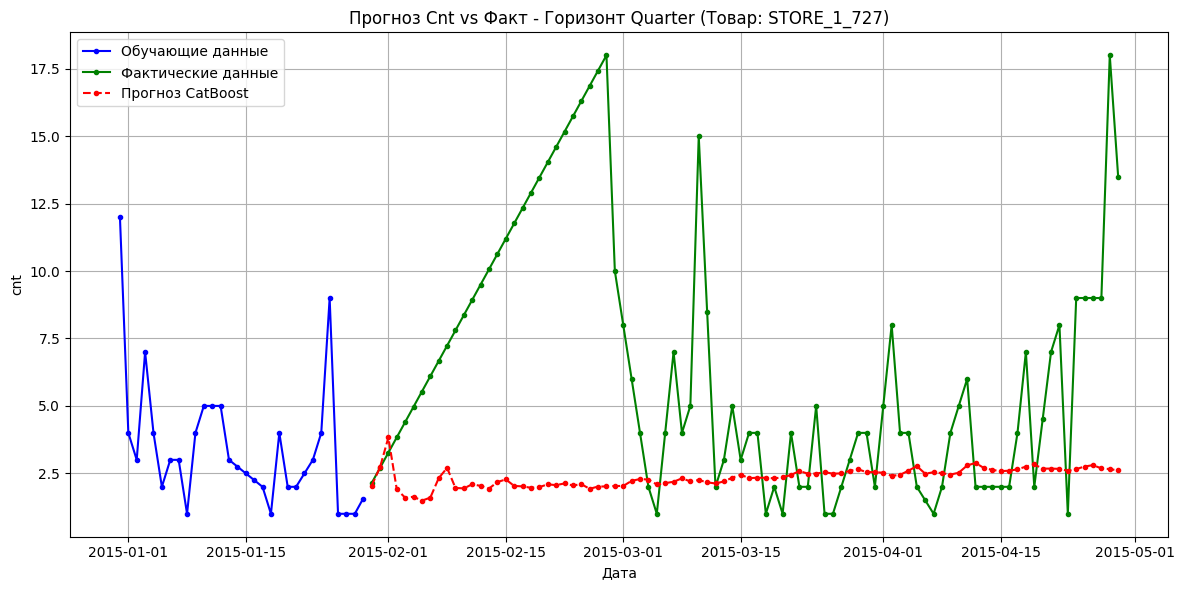


--- Итоговые результаты для товара STORE_1_727 ---
Horizon  MAE  RMSE  MAPE    R2
   week 1.83  2.37 39.50 -3.38
  month 8.01  9.28 71.26 -2.97
quarter 4.47  6.30 61.84 -0.79
Модель сохранена: models\catboost_STORE_1_727_cnt_model.cbm

--- Итоги агрегации прогнозов ---
Размер итогового недельного прогноза: (105, 2)
Размер итогового месячного прогноза: (450, 2)
Размер итогового квартального прогноза: (1350, 2)


In [1]:
import os
from src.forecasters import CatBoostForecaster 
import pandas as pd

# Конфигурация
DATA_DIR = 'data'
MODELS_DIR = 'models'
SALES_FILE = os.path.join(DATA_DIR, 'shop_sales.csv')
PRICES_FILE = os.path.join(DATA_DIR, 'shop_sales_prices.csv')
DATES_FILE = os.path.join(DATA_DIR, 'shop_sales_dates.csv')
STORE_ID_TO_PROCESS = 'STORE_1' 
TARGET_COLUMN = 'cnt'
TEST_SPLIT_SIZE = 0.2


# Создаем директорию для сохранения моделей
os.makedirs(MODELS_DIR, exist_ok=True)

# Создаем экземпляр класса
forecaster = CatBoostForecaster()

# Загружаем и предобрабатываем данные
print(f"Загрузка и предобработка данных для магазина: {STORE_ID_TO_PROCESS}...")
try:
    forecaster.load_and_preprocess_data(
        SALES_FILE,
        PRICES_FILE,
        DATES_FILE,
        store_id=STORE_ID_TO_PROCESS
    )
except FileNotFoundError as e:
    print(f"Ошибка: Не найден файл данных - {e}. Убедитесь, что файлы существуют.")
    exit() # Прерываем выполнение, если файлы не найдены
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")
    exit()

# Разделяем данные на обучающую и тестовую выборки один раз
print(f"Разделение данных на обучающую/тестовую выборки (test_size={TEST_SPLIT_SIZE})...")
forecaster.train_test_split(test_size=TEST_SPLIT_SIZE)

# Создаем пустые датафреймы для агрегации прогнозов по всем товарам
all_week_forecasts = pd.DataFrame()
all_month_forecasts = pd.DataFrame()
all_quarter_forecasts = pd.DataFrame()

# Прогнозирование по каждому товару
items_to_process = forecaster.items

if not items_to_process:
     print("\nНет товаров для обработки после разделения данных.")
else:
    print(f"\nНачинаем прогнозирование для {len(items_to_process)} товаров...")
    for item_id in items_to_process:
        print(f"\n=== Прогнозирование по товару {item_id} ===")
        
        # Запускаем полный цикл: обучение, прогноз на 3 горизонта, оценка, визуализация
        item_results_df = forecaster.run_all(target_col=TARGET_COLUMN, item_id=item_id)
        
        # Сбор агрегированных прогнозов ---
        week_key = f'CatBoost_{item_id}_{TARGET_COLUMN}_week'
        month_key = f'CatBoost_{item_id}_{TARGET_COLUMN}_month'
        quarter_key = f'CatBoost_{item_id}_{TARGET_COLUMN}_quarter'
        
        # Сохраняем модель в файл
        model_key = f'CatBoost_{item_id}_{TARGET_COLUMN}'
        if model_key in forecaster.models:
            model = forecaster.models[model_key]
            model_filename = os.path.join(MODELS_DIR, f'catboost_{item_id}_{TARGET_COLUMN}_model.cbm')
            try:
                model.save_model(model_filename)
                print(f"Модель сохранена: {model_filename}")
            except Exception as e:
                print(f"Ошибка сохранения модели {model_filename}: {e}")
        else:
             print(f"Предупреждение: Модель {model_key} не найдена в forecaster.models после run_all.")

        # Добавляем прогнозы к общим датафреймам
        if week_key in forecaster.forecasts:
            forecast_df = forecaster.forecasts[week_key].copy()
            forecast_df['item_id'] = item_id
            all_week_forecasts = pd.concat([all_week_forecasts, forecast_df], ignore_index=True) 
        else:
            print(f"Предупреждение: прогноз {week_key} не найден для агрегации")
            
        if month_key in forecaster.forecasts:
            forecast_df = forecaster.forecasts[month_key].copy()
            forecast_df['item_id'] = item_id
            all_month_forecasts = pd.concat([all_month_forecasts, forecast_df], ignore_index=True)
        else:
            print(f"Предупреждение: прогноз {month_key} не найден для агрегации")
            
        if quarter_key in forecaster.forecasts:
            forecast_df = forecaster.forecasts[quarter_key].copy()
            forecast_df['item_id'] = item_id
            all_quarter_forecasts = pd.concat([all_quarter_forecasts, forecast_df], ignore_index=True)
        else:
            print(f"Предупреждение: прогноз {quarter_key} не найден для агрегации")

# Выводим итоговые размеры агрегированных прогнозов
print("\n--- Итоги агрегации прогнозов ---")
print(f"Размер итогового недельного прогноза: {all_week_forecasts.shape}")
print(f"Размер итогового месячного прогноза: {all_month_forecasts.shape}")
print(f"Размер итогового квартального прогноза: {all_quarter_forecasts.shape}")


## 4. Анализ результатов и выводы

### 4.1 Какой подход из испробованных самый оптимальный с точки зрения качества прогнозирования?

В рамках класса `CatBoostForecaster` был реализован и протестирован **только один подход**: прогнозирование с использованием модели `CatBoostRegressor` на основе расширенного набора признаков, сгенерированных из временного ряда, с прямой обработкой категориальных признаков (включая типы событий).

Анализ важности признаков (см. логи) подтверждает, что модель использует релевантную информацию: прошлые продажи (`cnt_lag_1` часто самый важный), статистики скользящих окон, календарные факторы, а также экзогенные переменные, такие как кэшбэк (`CASHBACK_STORE_1`) и типы событий (`event_type_1`, `event_type_2`), где они оказываются значимыми.

Однако, анализ метрик на тестовой выборке (см. раздел 4.2) показывает **высокую вариативность результатов** между товарами и **существенное ухудшение точности** при увеличении горизонта прогнозирования. Несмотря на улучшения в предобработке (цены, категориальные признаки), подход "Feature Engineering + CatBoost" в его текущей реализации (с фиксированными гиперпараметрами) **не демонстрирует стабильно высокого и универсально оптимального качества** для всех товаров и горизонтов в магазине `STORE_1`. Он показывает потенциал, особенно на коротких горизонтах для некоторых товаров (например, `STORE_1_376` на недельном горизонте имеет R²=0.73), но требует дальнейшей настройки для повышения общей надежности.

### 4.2 Какое итоговое качество модели на тестовом датасете?

Итоговое качество модели `CatBoostRegressor` на тестовом датасете для магазина `STORE_1` представлено в таблице ниже, агрегирующей результаты по всем 15 проанализированным товарам для трех горизонтов прогнозирования (на основе предоставленных логов).

**Сводная таблица результатов CatBoost для `STORE_1` (Обновлено):**

| Товар        | Горизонт | MAE   | RMSE  | MAPE (%) | R2    |
| :----------- | :------- | :---- | :---- | :------- | :---- |
| STORE_1_064  | Неделя   | 0.01  | 0.01  | 0.55     | 0.00  |
|              | Месяц    | 0.29  | 0.42  | 26.07    | -2.81 |
|              | Квартал  | 0.36  | 0.45  | 28.11    | -0.40 |
| STORE_1_065  | Неделя   | 0.07  | 0.12  | 7.24     | 0.00  |
|              | Месяц    | 0.31  | 0.54  | 17.13    | -0.37 |
|              | Квартал  | 0.44  | 0.69  | 22.60    | -0.59 |
| STORE_1_325  | Неделя   | 1.85  | 2.10  | 79.99    | -0.13 |
|              | Месяц    | 3.80  | 5.20  | 73.43    | -0.41 |
|              | Квартал  | 4.19  | 5.40  | 66.11    | -0.67 |
| STORE_1_376  | Неделя   | 0.14  | 0.18  | 9.54     | 0.73  |
|              | Месяц    | 0.79  | 1.19  | 34.38    | -0.17 |
|              | Квартал  | 0.87  | 1.32  | 35.62    | -0.28 |
| STORE_1_090  | Неделя   | 19.93 | 22.28 | 24.41    | 0.34  |
|              | Месяц    | 20.20 | 27.19 | 36.61    | -0.59 |
|              | Квартал  | 19.23 | 26.95 | 86.90    | -0.13 |
| STORE_1_252  | Неделя   | 7.71  | 7.87  | 94.01    | -1.36 |
|              | Месяц    | 6.62  | 7.72  | 49.42    | -1.26 |
|              | Квартал  | 5.78  | 7.37  | 41.46    | -0.62 |
| STORE_1_339  | Неделя   | 1.59  | 1.94  | 37.44    | -0.26 |
|              | Месяц    | 2.23  | 2.56  | 92.52    | -0.12 |
|              | Квартал  | 2.55  | 3.25  | 112.62   | -0.07 |
| STORE_1_546  | Неделя   | 0.70  | 0.88  | 41.19    | -0.15 |
|              | Месяц    | 1.38  | 1.73  | 58.50    | -0.25 |
|              | Квартал  | 1.74  | 2.16  | 67.89    | 0.10  |
| STORE_1_547  | Неделя   | 3.54  | 3.72  | 27.80    | -0.86 |
|              | Месяц    | 5.20  | 6.47  | 43.55    | 0.04  |
|              | Квартал  | 6.34  | 9.68  | 74.89    | 0.04  |
| STORE_1_555  | Неделя   | 5.10  | 5.48  | 33.68    | 0.34  |
|              | Месяц    | 5.98  | 7.42  | 26.63    | 0.00  |
|              | Квартал  | 4.93  | 6.21  | 27.83    | 0.23  |
| STORE_1_584  | Неделя   | 2.73  | 4.00  | 64.49    | -0.46 |
|              | Месяц    | 1.68  | 2.58  | 60.24    | -0.17 |
|              | Квартал  | 2.38  | 2.90  | 132.56   | -1.55 |
| STORE_1_586  | Неделя   | 8.96  | 10.65 | 26.08    | -0.31 |
|              | Месяц    | 8.82  | 10.51 | 26.16    | -0.07 |
|              | Квартал  | 6.70  | 8.44  | 23.04    | 0.22  |
| STORE_1_587  | Неделя   | 8.18  | 9.25  | 32.70    | -1.80 |
|              | Месяц    | 9.66  | 12.28 | 34.23    | -1.13 |
|              | Квартал  | 10.24 | 12.90 | 31.79    | -0.86 |
| STORE_1_714  | Неделя   | 8.50  | 10.87 | 47.30    | 0.06  |
|              | Месяц    | 6.22  | 7.77  | 34.76    | 0.15  |
|              | Квартал  | 5.13  | 6.68  | 30.21    | 0.13  |
| STORE_1_727  | Неделя   | 1.83  | 2.37  | 39.50    | -3.38 |
|              | Месяц    | 8.01  | 9.28  | 71.26    | -2.97 |
|              | Квартал  | 4.47  | 6.30  | 61.84    | -0.79 |

**Анализ итогового качества (на основе новых логов):**

1.  **Вариативность:** Результаты по-прежнему сильно различаются между товарами. Например, `STORE_1_376` показывает хороший R² (0.73) на недельном горизонте, в то время как `STORE_1_727` имеет R²=-3.38 на том же горизонте.
2.  **Горизонт:** Тенденция к ухудшению метрик с увеличением горизонта сохраняется для большинства товаров. MAE и RMSE растут, MAPE часто становится очень большим, а R² часто уходит в отрицательную область, указывая, что модель работает хуже, чем простое предсказание среднего значения.
3.  **Влияние изменений:** Хотя были внесены улучшения в предобработку (цены, события), итоговые метрики не показывают кардинального улучшения по сравнению с предыдущим состоянием (судя по общей картине, без прямого сравнения чисел). Это подчеркивает, что основные ограничения текущей модели, вероятно, связаны не только с этими аспектами, но и с фиксированными гиперпараметрами и/или самой стратегией итеративного прогнозирования для длинных горизонтов.

**Формальный вывод:**
Итоговое качество модели `CatBoostRegressor` на тестовом датасете магазина `STORE_1`, даже после улучшений в предобработке цен и обработке категориальных признаков, остается **нестабильным и часто неудовлетворительным**, особенно для горизонтов прогнозирования месяц и квартал. Модель демонстрирует высокую чувствительность к конкретному товару и горизонту. Отрицательные значения R² для многих случаев указывают на неадекватность модели в текущей конфигурации с фиксированными гиперпараметрами. Накопление ошибки при итеративном прогнозировании остается вероятной причиной снижения точности на длинных горизонтах. Текущие результаты служат улучшенной базовой линией для ML-подхода, но для достижения приемлемого качества прогнозирования необходимы дальнейшие шаги: дальнейшее улучшение признаков или рассмотрение альтернативных стратегий прогнозирования (например, Direct Forecasting или другие алгоритмы).